# Compare and Calculate climatology and anomaly of ERA5/MERRA2 net shortwave and sst

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import json
import gcsfs
from scipy.signal import detrend
from scipy import stats
from scipy.stats import linregress
import cmocean

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

era23 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/gom_updated.zarr'))
era24_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-sst.zarr'))
era24_ssr = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-ssr.zarr'))
merra23 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean2023.zarr'))
#goes_t = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOES/datasets/sw_ds.zarr'))

era1022 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/surf_ds_2010_22.zarr'))
merra_1022 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean2010_2022.zarr'))

In [2]:
era_hrly = xr.concat([era1022, era23], dim='time')
#merra_hrly = xr.concat([merra_1022, merra23], dim='time')

In [3]:
era_hrly

<xarray.Dataset> Size: 23GB
Dimensions:    (time: 122712, latitude: 41, longitude: 113)
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 982kB 2010-01-01 ... 2023-12-31T23:00:00
Data variables:
    slhf       (time, latitude, longitude) float64 5GB dask.array<chunksize=(2374, 41, 113), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 5GB dask.array<chunksize=(2374, 41, 113), meta=np.ndarray>
    ssr        (time, latitude, longitude) float64 5GB dask.array<chunksize=(2374, 41, 113), meta=np.ndarray>
    sst        (time, latitude, longitude) float64 5GB dask.array<chunksize=(2374, 41, 113), meta=np.ndarray>
    str        (time, latitude, longitude) float64 5GB dask.array<chunksize=(2374, 41, 113), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-21 17:02:34 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

## SST Movie

In [5]:
sst_e = (era_hrly.sst-273.15).resample(time='D').mean()
sst_m = (merra_hrly.TSKINWTR-273.15).resample(time='D').mean()

In [6]:
sst_e.load()

<xarray.DataArray 'sst' (time: 5113, latitude: 41, longitude: 113)> Size: 190MB
array([[[        nan,         nan,         nan, ..., 22.62594429,
         22.39348871, 22.19641036],
        [        nan,         nan,         nan, ..., 22.88177605,
         22.58988673, 22.36300987],
        [        nan,         nan,         nan, ..., 23.0270948 ,
         22.59519332, 22.35492754],
        ...,
        [        nan,         nan,         nan, ..., 26.63015626,
         26.13528332, 25.70068772],
        [        nan,         nan,         nan, ..., 27.03590581,
         26.82005031, 26.48674243],
        [        nan,         nan,         nan, ..., 27.20370271,
         27.20514501, 27.10361238]],

       [[        nan,         nan,         nan, ..., 22.18598768,
         22.0036317 , 21.85937426],
        [        nan,         nan,         nan, ..., 22.4916469 ,
         22.23924401, 22.06126936],
        [        nan,         nan,         nan, ..., 22.65957986,
         22.27260746, 22.04118598],
...
        [        nan,         nan,         nan, ..., 26.97755201,
         26.64531424, 26.18478578],
        [        nan,         nan,         nan, ..., 27.10391459,
         27.02057457, 26.80238256],
        [        nan,         nan,         nan, ..., 27.20688096,
         27.24198968, 27.16431885]],

       [[        nan,         nan,         nan, ..., 21.41817382,
         21.56116987, 21.57314137],
        [        nan,         nan,         nan, ..., 21.424879  ,
         21.54004709, 21.64954598],
        [        nan,         nan,         nan, ..., 21.99366891,
         22.17142835, 22.286136  ],
        ...,
        [        nan,         nan,         nan, ..., 26.79481404,
         26.30858716, 25.48088489],
        [        nan,         nan,         nan, ..., 26.88390959,
         26.65236476, 26.37034396],
        [        nan,         nan,         nan, ..., 26.85303119,
         26.90819791, 26.82390823]]])
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 41kB 2010-01-01 2010-01-02 ... 2023-12-31

In [7]:
sst_m.load()

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,5))
sst_e[600].plot(cmap = cmocean.cm.thermal, vmin=20, vmax=34)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid();

In [ ]:
from xmovie import Movie
%matplotlib inline

In [ ]:
def plot_sst(da, fig, tt, *args, **kwargs):
    
    ax = fig.subplots()
    da.isel(time=tt).plot(ax=ax, cmap=cmocean.cm.thermal, vmin=20, vmax=34)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid();
    
    return ax, da

In [ ]:
sst_obj_e = Movie(sst_e, plot_sst, input_check=False)

In [ ]:
sst_obj_m = Movie(sst_m, plot_sst, input_check=False)

In [ ]:
sst_obj_e.preview(3)

In [ ]:
sst_obj_e.save('sst_e.mp4', overwrite_existing=True, progress=True,)

In [ ]:
sst_obj_m.save('sst_m.mp4', parallel=True, overwrite_existing=True, progress=True,
         parallel_compute_kwargs=dict(scheduler="processes", num_workers=8))

## 90$^{th}$ Percentile

In [ ]:
sst_e.quantile(q=0.9, dim=['latitude', 'longitude', 'time'])

## Shortwave

In [4]:
## convert from J/m^2 -> W/m^2
era_wm2 = era_hrly / (60*60)
#resample to daily freq (hourly too noisy
era_sliced_daily = era_wm2.sel(longitude=slice(-100, -80)).resample(time='D').mean('time')
#merra_daily = merra_hrly.sel(lon=slice(-100, -80)).resample(time='D').mean('time')
#merra_daily['EFLUXWTR'] = (-merra_daily.EFLUXWTR)
#merra_daily['HFLUXWTR'] = (-merra_daily.HFLUXWTR)

In [5]:
sst_era = (era_hrly.sst-273.15).sel(longitude=slice(-100, -80)).resample(time='D').mean('time')
#sst_merra = (merra_daily.sel(lon=slice(-100, -80)).TSKINWTR-273.15)

era_unsorted = xr.merge([era_sliced_daily.drop_vars('sst'), sst_era])
era = era_unsorted.sortby('latitude')
#merra = xr.merge([merra_daily.drop_vars('TSKINWTR'), sst_merra])

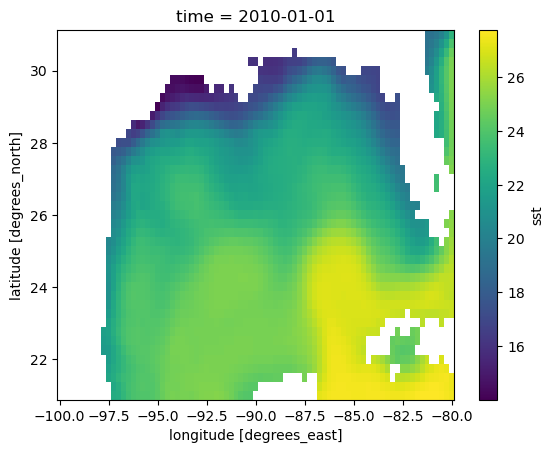

In [7]:
era.sst[0].plot()

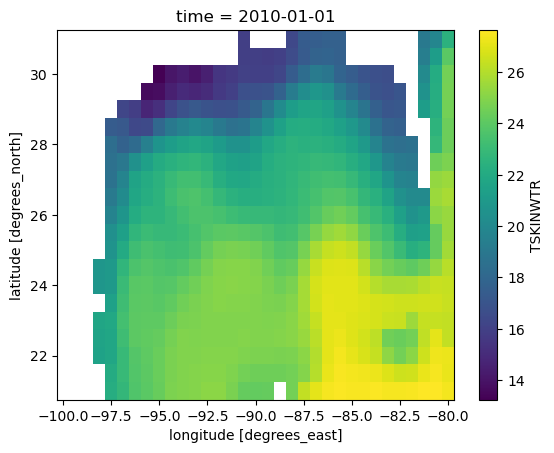

In [11]:
merra.TSKINWTR[0].plot()

In [6]:
era.load()

<xarray.Dataset> Size: 679MB
Dimensions:    (time: 5113, latitude: 41, longitude: 81)
Coordinates:
  * latitude   (latitude) float32 164B 21.0 21.25 21.5 21.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 41kB 2010-01-01 2010-01-02 ... 2023-12-31
Data variables:
    slhf       (time, latitude, longitude) float64 136MB -14.05 ... -380.4
    sshf       (time, latitude, longitude) float64 136MB -41.33 ... -123.3
    ssr        (time, latitude, longitude) float64 136MB 69.84 68.71 ... 145.2
    str        (time, latitude, longitude) float64 136MB -40.41 ... -140.9
    sst        (time, latitude, longitude) float64 136MB nan nan ... 21.19 23.63
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-21 17:02:34 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

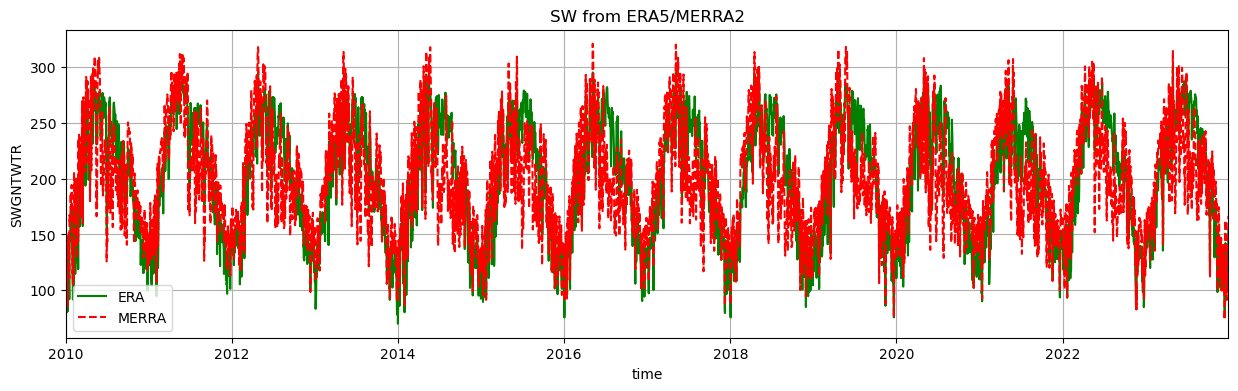

In [10]:
era.ssr.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='green', label='ERA')
#sw_goes.sel(time=slice('2023-01-01', '2023-09-30')).mean(['lat', 'lon']).plot(color='silver', label='GOES')
merra.SWGNTWTR.mean(['lat', 'lon']).plot(color='red', linestyle='--',label='MERRA')
plt.grid()
plt.legend()
plt.xlim(era.time.sel(time='2010-01-01', method='nearest'), 
         era.time.sel(time='2023-12-31', method='nearest'))
plt.title('SW from ERA5/MERRA2');

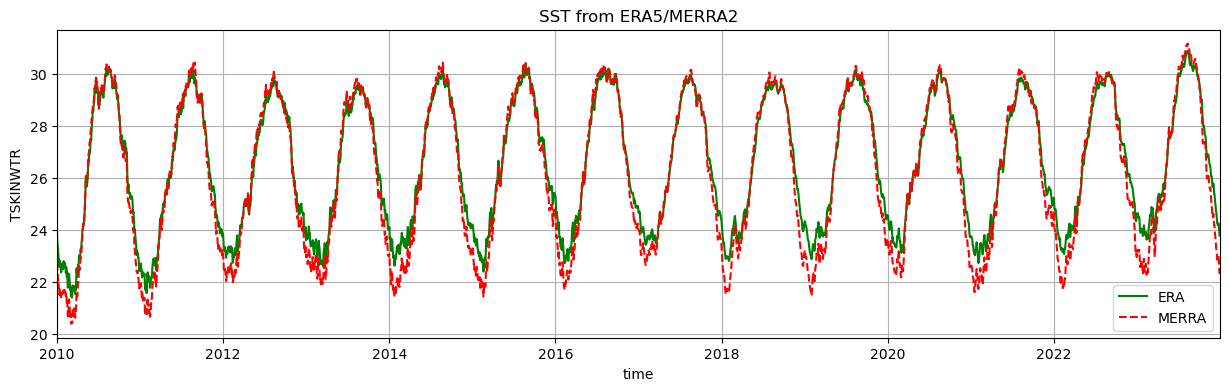

In [16]:
era.sst.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='green', label='ERA')
merra.TSKINWTR.mean(['lat', 'lon']).plot(color='red', linestyle='--',label='MERRA')
plt.grid()
plt.legend()
plt.xlim(era.time.sel(time='2010-01-01', method='nearest'), 
         era.time.sel(time='2023-12-31', method='nearest'))
plt.title('SST from ERA5/MERRA2');

In [7]:
era.coords

Coordinates:
  * latitude   (latitude) float32 164B 21.0 21.25 21.5 21.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 41kB 2010-01-01 2010-01-02 ... 2023-12-31

In [8]:
era24_ssr.coords

Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 29kB 2024-01-01 ... 2024-05-31T23:00:00

In [9]:
era24_sst.coords

Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 29kB 2024-01-01 ... 2024-05-31T23:00:00

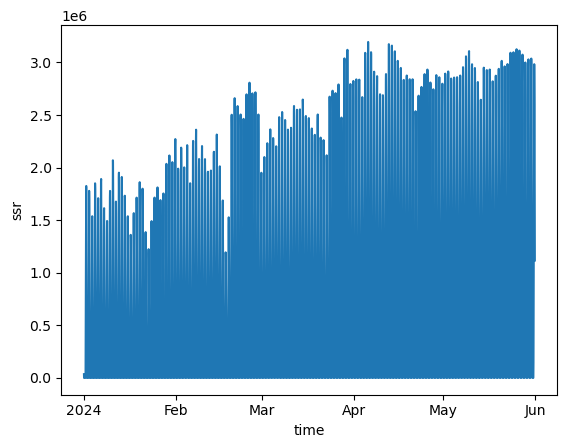

In [30]:
(era24_ssr.ssr/60*60).mean(['latitude', 'longitude']).plot()

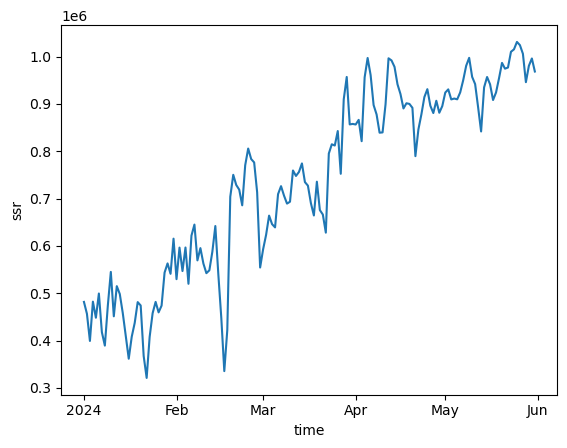

In [32]:
(era24_ssr.ssr/60*60).mean(['latitude', 'longitude']).resample(time='D').mean('time').plot()

In [33]:
era24_ssr.ssr.coords

Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 29kB 2024-01-01 ... 2024-05-31T23:00:00

In [7]:
sst24 = (era24_sst.sst-273.15).sel(longitude=slice(None, -80)).resample(time='D').mean('time')
sst = xr.merge([era.sst, sst24])

ssr24 = (era24_ssr.ssr / (60*60)).resample(time='D').mean('time').sortby('latitude')
sw1 = xr.merge([era.ssr, ssr24])
sw = sw1.ssr

In [8]:
sw.load()

<xarray.DataArray 'ssr' (time: 5265, latitude: 41, longitude: 81)> Size: 140MB
array([[[ 69.84066677,  68.71477416,  69.49962343, ..., 185.73310324,
         186.5410741 , 187.04461078],
        [ 84.28908678,  84.44387293,  85.66289414, ..., 183.94246513,
         184.90136854, 185.76007842],
        [101.3598796 , 101.29372618, 101.50053589, ..., 182.11457558,
         183.20835489, 184.25846009],
        ...,
        [140.91255781, 141.81365726, 141.78796662, ...,  28.41770944,
          25.651469  ,  22.91605733],
        [138.67040657, 139.14182995, 139.13412276, ...,  36.83396547,
          33.99900255,  30.60012992],
        [136.04996056, 136.44816559, 136.6569021 , ...,  46.06076143,
          43.43389275,  39.54240196]],

       [[102.19097204, 102.84479901, 105.54938189, ..., 190.92967891,
         186.27196457, 180.95978099],
        [ 99.70026379,  99.85890353,  99.47482836, ..., 193.57838464,
         190.49036884, 187.44538488],
        [ 98.24039276,  95.97062407,  93.42082734, ..., 194.8250233 ,
         193.81859219, 192.06263646],
...
        [196.08966788, 189.63528306, 182.32770707, ..., 314.82438745,
         316.10354407, 316.58685102],
        [198.99076988, 193.3297142 , 187.3195685 , ..., 313.85651329,
         314.53515943, 314.27869798],
        [201.90195389, 199.5257472 , 194.91889301, ..., 313.49482073,
         313.75947382, 312.41478406]],

       [[285.97467986, 284.89149256, 285.95451582, ..., 276.02309346,
         280.67846738, 285.5197286 ],
        [284.81650752, 284.59974404, 282.43715019, ..., 283.36721678,
         286.87134975, 288.97471171],
        [285.35463548, 284.94694369, 282.99733257, ..., 286.99170389,
         285.82786041, 283.95386447],
        ...,
        [187.65164511, 184.43926067, 186.71086638, ..., 320.28065204,
         319.07522022, 314.50428324],
        [194.48410579, 189.02280018, 189.43049197, ..., 320.82571139,
         319.70912739, 316.37071767],
        [202.41487679, 195.03924715, 193.09908793, ..., 320.85910809,
         319.87359038, 319.09286376]]])
Coordinates:
  * latitude   (latitude) float32 164B 21.0 21.25 21.5 21.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 42kB 2010-01-01 2010-01-02 ... 2024-05-31

In [9]:
sst.load()

<xarray.Dataset> Size: 140MB
Dimensions:    (latitude: 41, longitude: 81, time: 5265)
Coordinates:
  * latitude   (latitude) float32 164B 21.0 21.25 21.5 21.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 42kB 2010-01-01 2010-01-02 ... 2024-05-31
Data variables:
    sst        (time, latitude, longitude) float64 140MB nan nan ... 26.24 27.3

In [15]:
sst_e = sst.mean(['latitude', 'longitude'])
sw_e = sw.mean(['latitude', 'longitude'])
#sst_m = merra.TSKINWTR.mean(['lat', 'lon'])

In [34]:
lr_e = linregress(np.arange(0,5262), sst_e.fillna(0.))
#lr_m = linregress(np.arange(0,5113), sst_m.fillna(0.))

In [35]:
lr_e

LinregressResult(slope=0.00010102777194842721, intercept=26.03639119102623, rvalue=0.05537983798449046, pvalue=5.8355473102455994e-05, stderr=2.511477110227652e-05, intercept_stderr=0.07628822938407064)

In [20]:
lr_m

LinregressResult(slope=0.0002187805327021101, intercept=25.621878417296518, rvalue=0.11267032867139269, pvalue=6.461314274507503e-16, stderr=2.698807629925164e-05, intercept_stderr=0.07965689706847169)

In [37]:
trend_e = (lr_e[0]*np.arange(0, 5262) + lr_e[1])
#trend_m = (lr_m[0]*np.arange(0, 5113) + lr_m[1])

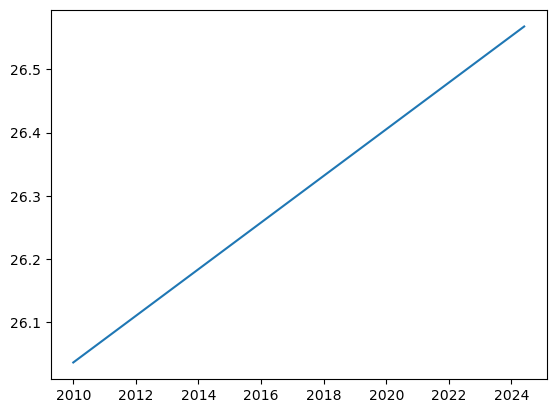

In [39]:
plt.plot(sst.time, trend_e)

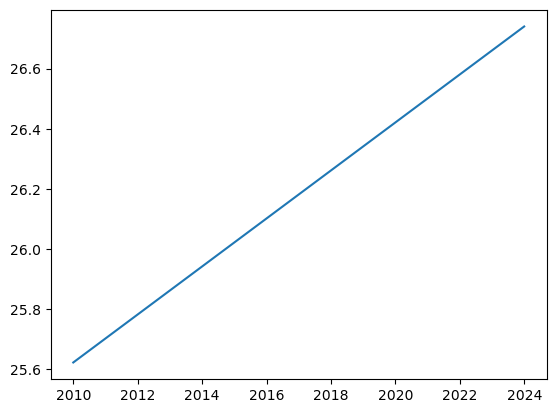

In [22]:
plt.plot(merra.time, trend_m)

In [47]:
sst_e

<xarray.DataArray 'sst' (time: 5262)> Size: 42kB
array([23.19436885, 22.89363535, 22.75537482, ..., 14.89747686,
       13.52154155, 12.92419895])
Coordinates:
  * time     (time) datetime64[ns] 42kB 2010-01-01 2010-01-02 ... 2024-05-28

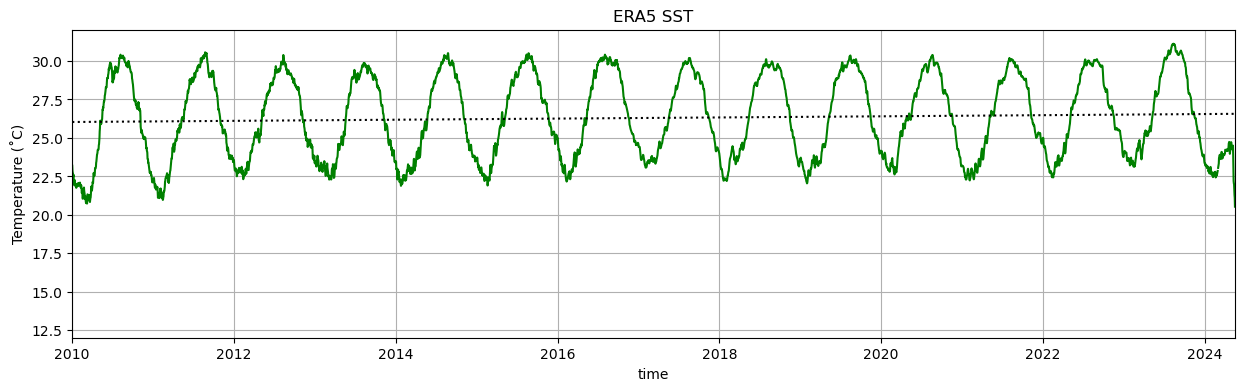

In [54]:
sst_e.plot(figsize=(15,4), color='green')
plt.plot(sst.time, trend_e, color='k', linestyle='dotted')
plt.grid()
plt.ylabel('Temperature (˚C)')
plt.xlim(sst.time.sel(time='2010-01-01', method='nearest'), 
         sst.time.sel(time='2024-05-15', method='nearest'))
plt.title('ERA5 SST');

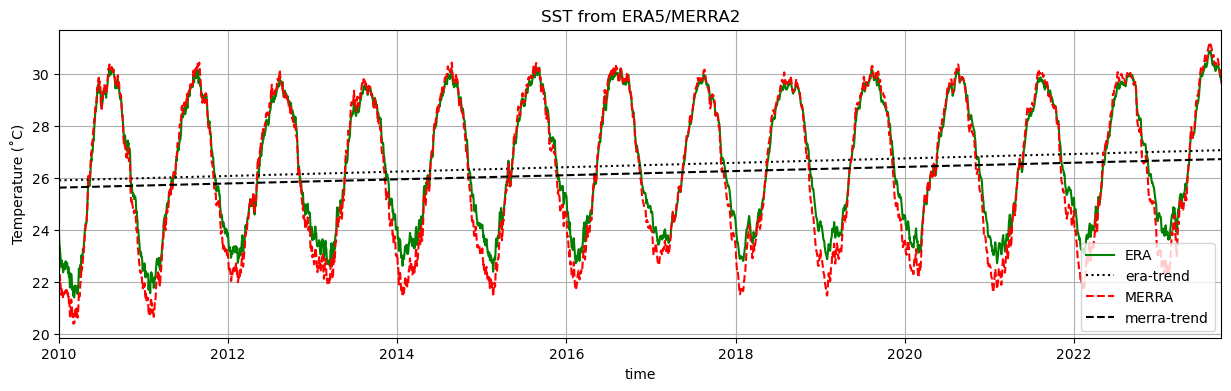

In [24]:
sst_e.plot(figsize=(15,4), color='green', label='ERA')
plt.plot(era.time, trend_e, label='era-trend', color='k', linestyle='dotted')
sst_m.plot(color='red', linestyle='--',label='MERRA')
plt.plot(merra.time, trend_m, label='merra-trend', color='k', linestyle='--')
plt.grid()
plt.legend()
plt.ylabel('Temperature (˚C)')
plt.xlim(era.time.sel(time='2010-01-01', method='nearest'), 
         era.time.sel(time='2023-10-01', method='nearest'))
plt.title('SST from ERA5/MERRA2');

# Monthly climatology

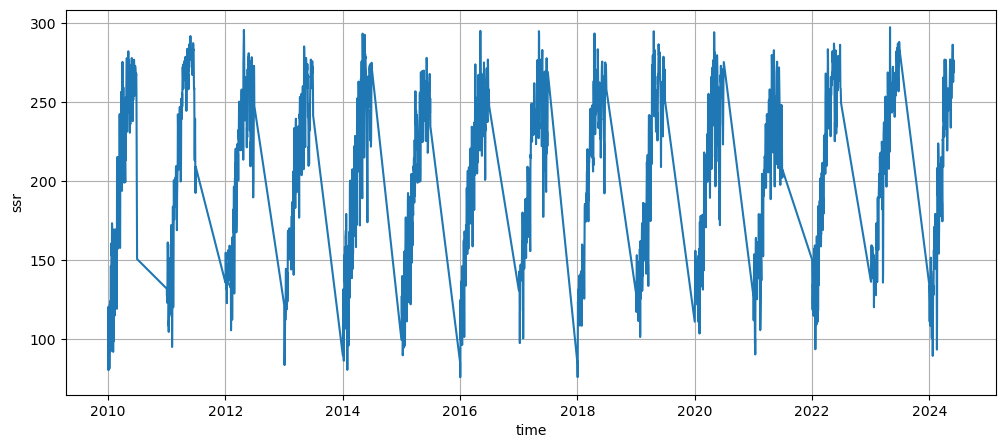

In [10]:
#only keep jan to may months
jan_may = sw.sel(time=sw.time.dt.month.isin([1, 2, 3, 4, 5, 6]))
sw_jan_may = sw.where(sw.time==jan_may.time)

#compare all the jan-may months since 2010
sw_jan_may.mean(['latitude', 'longitude']).plot(figsize=(12,5))
plt.grid()

In [11]:
mo_clim_e_sst = sst.groupby('time.month').mean(['time', 'latitude', 'longitude'])
mo_anom_e_sst = sst.groupby('time.month') - mo_clim_e_sst

emonthly_sst = sst.resample(time='ME').mean().mean(['latitude', 'longitude'])

mo_clim_e_ssr = sw.groupby('time.month').mean(['time', 'latitude', 'longitude'])
mo_anom_e_ssr = sw.groupby('time.month') - mo_clim_e_ssr

emonthly_ssr = sw.resample(time='ME').mean().mean(['latitude', 'longitude'])

In [27]:
sw.sel(time=slice('2024', '2024')).resample(time='ME').mean('time').mean(['latitude', 'longitude'])

<xarray.DataArray 'ssr' (time: 5)> Size: 40B
array([128.29534638, 170.86056241, 204.70417563, 250.37696176,
       265.26553258])
Coordinates:
  * time     (time) datetime64[ns] 40B 2024-01-31 2024-02-29 ... 2024-05-31

In [12]:
emonthly_ssr.sel(time='2024')

<xarray.DataArray 'ssr' (time: 5)> Size: 40B
array([128.29534638, 170.86056241, 204.70417563, 250.37696176,
       265.26553258])
Coordinates:
  * time     (time) datetime64[ns] 40B 2024-01-31 2024-02-29 ... 2024-05-31

In [15]:
emonthly_ssr

<xarray.DataArray 'ssr' (time: 173)> Size: 1kB
array([126.1323878 , 149.07445272, 210.29576947, 237.73222387,
       262.97742814, 253.20445278, 239.77953689, 230.68489879,
       204.94108311, 197.48138011, 151.55272397, 129.99875691,
       136.55651016, 169.8944024 , 218.46399132, 264.92783009,
       274.52264251, 257.50031847, 251.03269049, 248.88140705,
       216.05047203, 181.00511519, 149.42714589, 123.4260721 ,
       143.5830702 , 149.32198197, 213.52268619, 251.17788367,
       256.25104088, 240.41795612, 251.5767315 , 232.26433507,
       210.62606233, 184.16928662, 148.00334279, 130.95136623,
       131.15441735, 168.90064623, 214.56402734, 231.2283509 ,
       256.50784015, 253.03538724, 240.1645351 , 233.93537266,
       195.7908747 , 177.99639269, 128.35578332, 119.6302221 ,
       131.26577708, 162.71164904, 195.19404735, 240.60685601,
       255.17505187, 247.48015639, 257.3092121 , 244.04400509,
       196.71336302, 186.23559057, 135.73508184, 122.7594684 ,
       129.04237253, 156.9604438 , 196.0203149 , 223.34241977,
       253.96502058, 250.93049164, 261.40499362, 242.70756003,
       201.49101968, 177.65417801, 136.3753491 , 121.38447263,
       124.91687814, 175.72052998, 198.09308677, 239.74120206,
       253.59341367, 248.17469154, 258.37687   , 225.98480035,
...
       124.95357889, 164.31748802, 214.04531355, 245.05013612,
       247.31531328, 252.63913328, 256.16817054, 237.45882677,
       199.92652603, 173.73860702, 130.96350839, 120.70576681,
       134.36175753, 162.63135465, 196.67286829, 250.28307823,
       258.50602249, 252.93190391, 247.31736557, 236.75848266,
       216.78346007, 170.40785632, 143.38212458, 125.23698332,
       134.35258992, 160.01284758, 214.17650879, 240.71284802,
       251.51074395, 241.52602892, 247.6444804 , 241.49832121,
       200.41890167, 172.9687712 , 145.61956988, 126.22934937,
       136.71582765, 159.8927555 , 212.01046361, 239.01390142,
       249.83205862, 233.33497194, 243.55473565, 235.3751948 ,
       203.44123817, 182.65203939, 146.75118105, 134.80726916,
       131.42548981, 162.5835115 , 215.02618064, 249.28748523,
       264.62133094, 266.19714147, 257.96286074, 231.63983661,
       210.56325941, 184.66998526, 135.51854841, 124.9034808 ,
       143.9582024 , 174.13642881, 208.19885775, 235.59816811,
       258.25185283, 272.45560714, 261.42972585, 249.25041377,
       223.48512701, 175.65249988, 133.65721022, 116.79256036,
       128.29534638, 170.86056241, 204.70417563, 250.37696176,
       265.26553258])
Coordinates:
  * time     (time) datetime64[ns] 1kB 2010-01-31 2010-02-28 ... 2024-05-31

In [16]:
#expand 2024 so you can plot it below
import pandas as pd

date_range = ['2024-01-31T00:00:00.000000000', '2024-02-29T00:00:00.000000000',
       '2024-03-31T00:00:00.000000000', '2024-04-30T00:00:00.000000000',
       '2024-05-31T00:00:00.000000000', '2024-06-30T00:00:00.000000000',
       '2024-07-31T00:00:00.000000000', '2024-08-31T00:00:00.000000000',
       '2024-09-30T00:00:00.000000000', '2024-10-31T00:00:00.000000000',
       '2024-11-30T00:00:00.000000000', '2024-12-31T00:00:00.000000000']
months2024 = pd.to_datetime(date_range)

#first 5 values come from latest May data 
array_sst = [23.0136254 , 22.64149763, 23.84178295, 24.6643005 , 27.42317793, np.nan,
             np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
array_ssr = [128.29534638, 159.27655128, 164.5035068 , 164.83448341, 171.77060865, np.nan,
             np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

array_sst2024 = xr.DataArray(data=array_sst, coords={'time':months2024})
array_ssr2024 = xr.DataArray(data=array_ssr, coords={'time':months2024})

#insert to emonthly
emonthly_filled_sst = xr.concat([emonthly_sst.sst.sel(time=slice(None, '2023')), array_sst2024], dim='time')
emonthly_filled_ssr = xr.concat([emonthly_ssr.sel(time=slice(None, '2023')), array_ssr2024], dim='time')

In [17]:
emonthly_filled_sst

<xarray.DataArray 'sst' (time: 180)> Size: 1kB
array([22.15241612, 21.59724194, 21.14335117, 23.10298935, 26.4575525 ,
       29.19267256, 29.27902262, 30.17203279, 29.52825182, 27.40065912,
       25.41962962, 23.09278922, 21.71564581, 21.55251193, 22.92808594,
       24.92295246, 26.42721757, 28.3493517 , 29.31613964, 30.22656283,
       29.32475497, 27.66009924, 25.43873273, 23.84759793, 22.89313933,
       22.78035223, 23.85213504, 25.15120063, 26.86851915, 28.35648207,
       29.36845497, 29.74652505, 29.0194808 , 27.96183569, 25.58814447,
       24.28351964, 23.29152092, 23.01886469, 22.60734859, 24.03494145,
       25.81441031, 28.51455046, 29.04459802, 29.65871109, 29.17091236,
       28.07585271, 25.87713162, 24.16334146, 22.49057993, 22.60936596,
       22.99800455, 24.21348621, 25.8776014 , 28.10927451, 29.45372892,
       30.20188984, 29.58983363, 28.14446938, 25.39571482, 23.92163928,
       23.01726348, 22.35543909, 23.64139041, 25.47390799, 26.93085895,
       28.72043832, 29.54010147, 30.18804506, 29.70240222, 28.08244746,
       26.72616445, 25.2024296 , 23.6068758 , 22.57141129, 23.35894529,
       24.65749034, 26.87553712, 28.98290528, 30.06476867, 30.10097697,
       29.84242183, 28.53568898, 26.37168058, 24.85225028, 23.81253737,
       23.39755052, 23.66892544, 24.81745325, 26.23008529, 28.00471399,
       29.5039663 , 29.92920565, 29.21954605, 28.27915123, 26.1454577 ,
       24.57974386, 22.71767536, 23.24927443, 23.73880816, 24.50922147,
       26.51331802, 28.50918635, 29.51101265, 29.76509735, 29.56107235,
       28.6887264 , 26.25766647, 23.94766758, 22.92091591, 22.89604773,
       23.46572101, 24.34782651, 26.73871191, 28.8456233 , 29.60979901,
       30.05025988, 29.71051019, 28.70274707, 26.32263204, 24.701859  ,
       23.63801156, 23.10064329, 23.90304096, 25.81688575, 26.78339221,
       28.30715352, 29.51809548, 30.01971554, 29.54550004, 27.9352995 ,
       26.27030064, 24.08849754, 22.75201569, 22.62815456, 23.34719426,
       24.62234457, 26.59150056, 28.3349603 , 29.24395649, 29.97350664,
       29.31706107, 28.49581128, 26.07094035, 25.05642191, 23.79621688,
       22.80037646, 23.54356725, 24.76095979, 27.05852927, 28.75372796,
       29.87911046, 29.9098537 , 29.7079083 , 27.73295913, 26.31184504,
       24.93289195, 23.73645184, 23.4834764 , 24.33848373, 25.34409156,
       26.98251896, 28.88106732, 30.34686098, 30.86567541, 30.41412671,
       28.60980692, 26.32200225, 24.39686312, 23.0136254 , 22.64149763,
       23.84178295, 24.6643005 , 27.42317793,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])
Coordinates:
  * time     (time) datetime64[ns] 1kB 2010-01-31 2010-02-28 ... 2024-12-31

In [21]:
emonthly_filled_ssr

<xarray.DataArray 'ssr' (time: 180)> Size: 1kB
array([126.1323878 , 149.07445272, 210.29576947, 237.73222387,
       262.97742814, 253.20445278, 239.77953689, 230.68489879,
       204.94108311, 197.48138011, 151.55272397, 129.99875691,
       136.55651016, 169.8944024 , 218.46399132, 264.92783009,
       274.52264251, 257.50031847, 251.03269049, 248.88140705,
       216.05047203, 181.00511519, 149.42714589, 123.4260721 ,
       143.5830702 , 149.32198197, 213.52268619, 251.17788367,
       256.25104088, 240.41795612, 251.5767315 , 232.26433507,
       210.62606233, 184.16928662, 148.00334279, 130.95136623,
       131.15441735, 168.90064623, 214.56402734, 231.2283509 ,
       256.50784015, 253.03538724, 240.1645351 , 233.93537266,
       195.7908747 , 177.99639269, 128.35578332, 119.6302221 ,
       131.26577708, 162.71164904, 195.19404735, 240.60685601,
       255.17505187, 247.48015639, 257.3092121 , 244.04400509,
       196.71336302, 186.23559057, 135.73508184, 122.7594684 ,
       129.04237253, 156.9604438 , 196.0203149 , 223.34241977,
       253.96502058, 250.93049164, 261.40499362, 242.70756003,
       201.49101968, 177.65417801, 136.3753491 , 121.38447263,
       124.91687814, 175.72052998, 198.09308677, 239.74120206,
       253.59341367, 248.17469154, 258.37687   , 225.98480035,
...
       247.31531328, 252.63913328, 256.16817054, 237.45882677,
       199.92652603, 173.73860702, 130.96350839, 120.70576681,
       134.36175753, 162.63135465, 196.67286829, 250.28307823,
       258.50602249, 252.93190391, 247.31736557, 236.75848266,
       216.78346007, 170.40785632, 143.38212458, 125.23698332,
       134.35258992, 160.01284758, 214.17650879, 240.71284802,
       251.51074395, 241.52602892, 247.6444804 , 241.49832121,
       200.41890167, 172.9687712 , 145.61956988, 126.22934937,
       136.71582765, 159.8927555 , 212.01046361, 239.01390142,
       249.83205862, 233.33497194, 243.55473565, 235.3751948 ,
       203.44123817, 182.65203939, 146.75118105, 134.80726916,
       131.42548981, 162.5835115 , 215.02618064, 249.28748523,
       264.62133094, 266.19714147, 257.96286074, 231.63983661,
       210.56325941, 184.66998526, 135.51854841, 124.9034808 ,
       143.9582024 , 174.13642881, 208.19885775, 235.59816811,
       258.25185283, 272.45560714, 261.42972585, 249.25041377,
       223.48512701, 175.65249988, 133.65721022, 116.79256036,
       128.29534638, 159.27655128, 164.5035068 , 164.83448341,
       171.77060865,          nan,          nan,          nan,
                nan,          nan,          nan,          nan])
Coordinates:
  * time     (time) datetime64[ns] 1kB 2010-01-31 2010-02-28 ... 2024-12-31

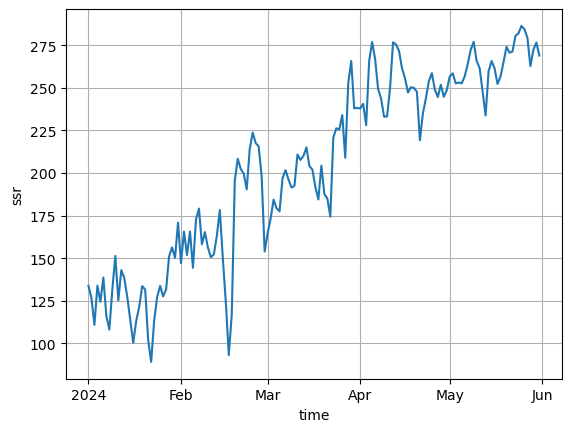

In [18]:
ssr24.mean(['latitude', 'longitude']).plot()
plt.grid()

In [21]:
mo_clim_e_sst

<xarray.DataArray 'sst' (month: 12)> Size: 96B
array([23.03699276, 22.71272578, 23.35845232, 24.69600346, 26.63819541,
       28.56157912, 29.54854398, 30.05771841, 29.54669874, 28.16468244,
       26.03700306, 24.36196517])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

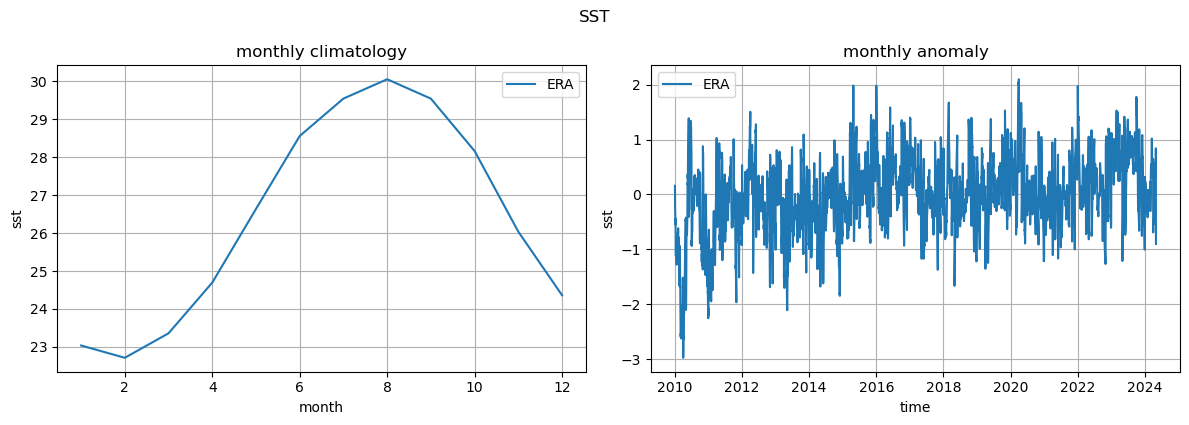

In [20]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

mo_clim_e_sst.sst.plot(ax=ax0, label='ERA')
#mo_clim_m.TSKINWTR.plot(ax=ax0, label='MERRA')
ax0.set_title('monthly climatology')
ax0.grid()
ax0.legend()

mo_anom_e_sst.sst.mean(['latitude', 'longitude']).sel(time=slice('2010', '2024-05-01')).plot(label='ERA', ax=ax1)
#mo_anom_m.TSKINWTR.mean(['lat', 'lon']).plot(ax=ax1, label='MERRA', linestyle='--')
ax1.set_title('monthly anomaly')
ax1.grid()
ax1.legend()

plt.tight_layout()
plt.suptitle('SST', y=1.05);

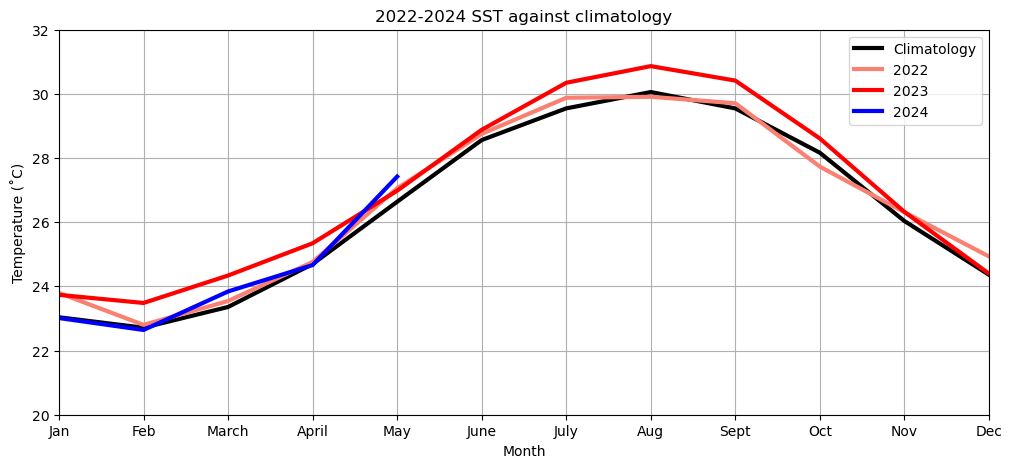

In [21]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]
plt.figure(figsize=(12,5))
plt.plot(months, mo_clim_e_sst.sst, label='Climatology', color='k', linewidth=3)
plt.plot(months, emonthly_filled_sst.sel(time=slice('2022', '2022')), label='2022', linewidth=3, color='salmon')
plt.plot(months, emonthly_filled_sst.sel(time=slice('2023', '2023')), label='2023', linewidth=3, color='red')
plt.plot(months, emonthly_filled_sst.sel(time=slice('2024', '2024')), label='2024', linewidth=3, color='blue')
plt.xlim('Jan', 'Dec')
plt.ylim(20,32)
plt.grid()
plt.legend()
plt.ylabel('Temperature (˚C)')
plt.xlabel('Month')
plt.title('2022-2024 SST against climatology');
plt.savefig('paper-figs/era/sst-clim-line-plot.pdf')

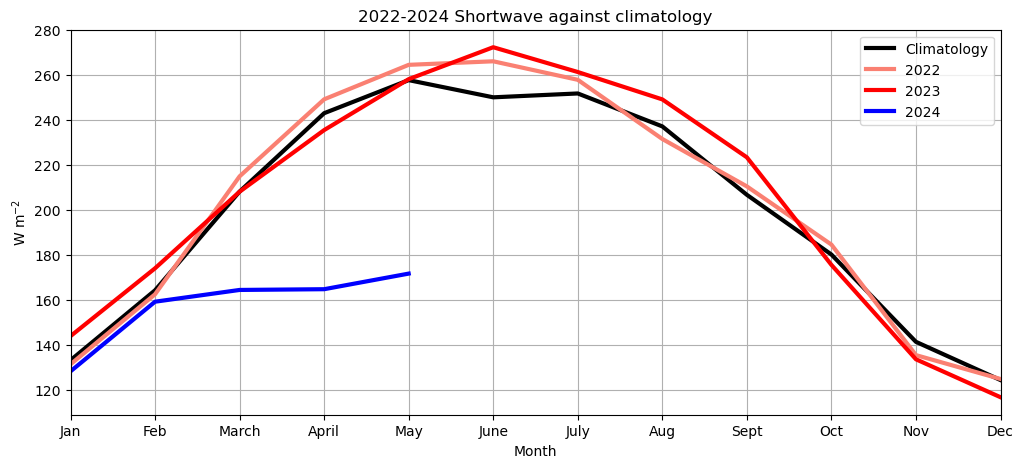

In [23]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]
plt.figure(figsize=(12,5))
plt.plot(months, mo_clim_e_ssr, label='Climatology', color='k', linewidth=3)
plt.plot(months, emonthly_filled_ssr.sel(time=slice('2022', '2022')), label='2022', linewidth=3, color='salmon')
plt.plot(months, emonthly_filled_ssr.sel(time=slice('2023', '2023')), label='2023', linewidth=3, color='red')
plt.plot(months, emonthly_filled_ssr.sel(time=slice('2024', '2024')), label='2024', linewidth=3, color='blue')
plt.xlim('Jan', 'Dec')
#plt.ylim(20,32)
plt.grid()
plt.legend()
plt.ylabel(r'W m$^{-2}$')
plt.xlabel('Month')
plt.title('2022-2024 Shortwave against climatology');
#plt.savefig('paper-figs/era/ssr-clim-line-plot.pdf')

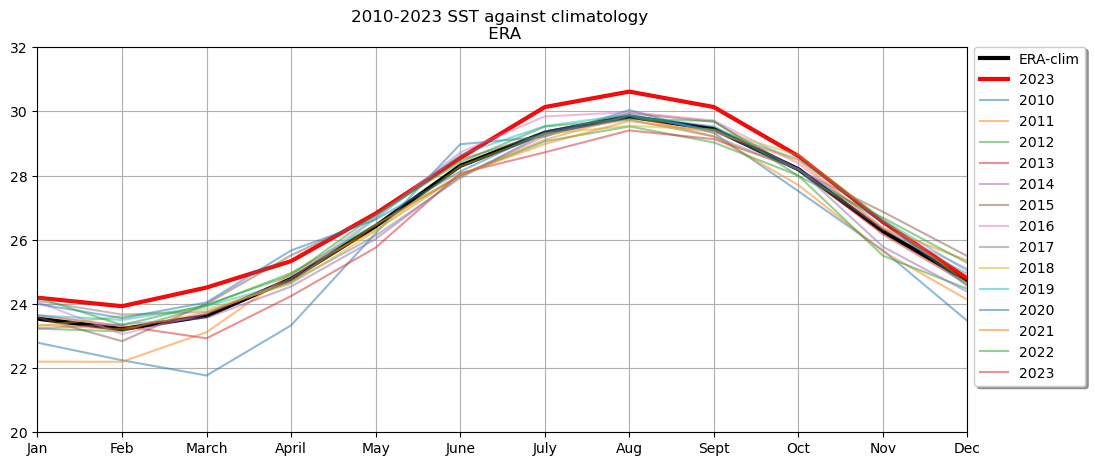

In [28]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]

plt.figure(figsize=(12,5))
plt.plot(months, mo_clim_e.sst, label='ERA-clim', color='k', linewidth=3)
plt.plot(months, emonthly.sst.sel(time=slice('2023', '2023')), label='2023', linewidth=3, color='red')
plt.xlim('Jan', 'Dec')
plt.grid()
plt.ylim(20,32)
plt.title('2010-2023 SST against climatology \n ERA');

for i in np.unique(emonthly.sst.time.dt.year[:-1]):
    plt.plot(months, emonthly.sst[emonthly.sst.time.dt.year == i], label=f'{i}', alpha=0.5)
    plt.legend(bbox_to_anchor=(1., 1.02), fancybox=True, shadow=True)

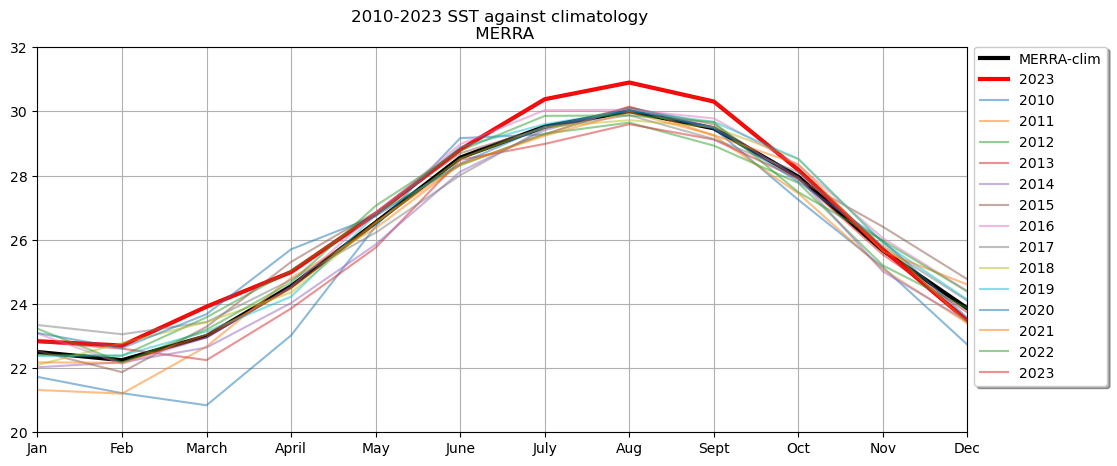

In [32]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]

plt.figure(figsize=(12,5))
plt.plot(months, mo_clim_m.TSKINWTR, label='MERRA-clim', color='k', linewidth=3)
plt.plot(months, mmonthly.TSKINWTR.sel(time=slice('2023', '2023')), label='2023', linewidth=3, color='red')
plt.xlim('Jan', 'Dec')
plt.grid()
plt.ylim(20,32)
plt.title('2010-2023 SST against climatology \n MERRA');

for i in np.unique(mmonthly.TSKINWTR.time.dt.year[:-1]):
    plt.plot(months, mmonthly.TSKINWTR[mmonthly.TSKINWTR.time.dt.year == i], label=f'{i}', alpha=0.5)
    plt.legend(bbox_to_anchor=(1., 1.02), fancybox=True, shadow=True)

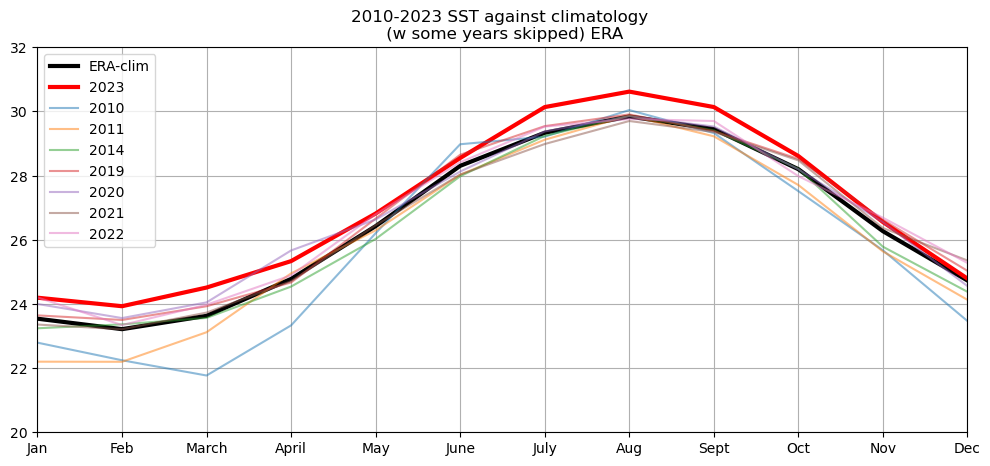

In [33]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]
yrs2keep = ['2010', '2011', '2014', '2019', '2020', '2021', '2022']
#years = np.arange(12, 180, 12)
#labels = [str(x) for x in sst_edaily.groupby('time.year').mean().year.values]
#drop_index = [2,3,5,6,7,8]

plt.figure(figsize=(12,5))
plt.plot(months, mo_clim_e.sst, label='ERA-clim', color='k', linewidth=3)
plt.plot(months, emonthly.sst.sel(time=slice('2023', '2023')), label='2023', linewidth=3, color='red')
plt.xlim('Jan', 'Dec')
plt.grid()
plt.ylim(20,32)
plt.title('2010-2023 SST against climatology \n (w some years skipped) ERA');

for i in np.unique(emonthly.sst.time.dt.year):
    if str(i) in yrs2keep:
        plt.plot(months, emonthly.sst[emonthly.sst.time.dt.year == i], label=f'{i}', alpha=0.5)
        plt.legend()

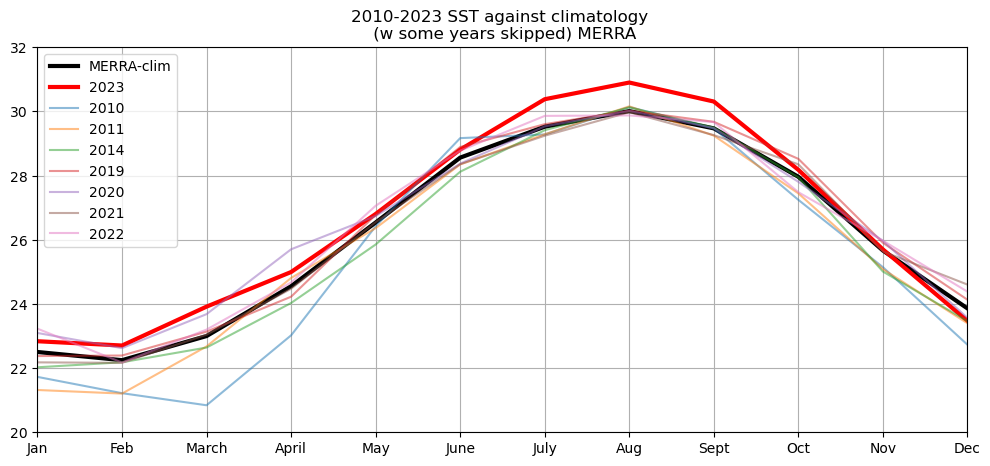

In [34]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]
yrs2keep = ['2010', '2011', '2014', '2019', '2020', '2021', '2022']

plt.figure(figsize=(12,5))
plt.plot(months, mo_clim_m.TSKINWTR, label='MERRA-clim', color='k', linewidth=3)
plt.plot(months, mmonthly.TSKINWTR.sel(time=slice('2023', '2023')), label='2023', linewidth=3, color='red')
plt.xlim('Jan', 'Dec')
plt.grid()
plt.ylim(20,32)
plt.title('2010-2023 SST against climatology \n (w some years skipped) MERRA');

for i in np.unique(mmonthly.TSKINWTR.time.dt.year):
    if str(i) in yrs2keep:
        plt.plot(months, mmonthly.TSKINWTR[mmonthly.TSKINWTR.time.dt.year == i], label=f'{i}', alpha=0.5)
        plt.legend()

In [36]:
import numpy as np

for (i,j) in zip(np.arange(1,13), range(12)):
    print(i,': ', f'{mo_clim_e.sst.values[j]}')

1 :  23.54005519242733
2 :  23.214056164405537
3 :  23.62872674720739
4 :  24.780422846585367
5 :  26.42571455449896
6 :  28.304328225558233
7 :  29.3364938172974
8 :  29.84244611521702
9 :  29.44964407120014
10 :  28.19976881484067
11 :  26.26737517961165
12 :  24.730202251708075


In [37]:
for (i,j) in zip(np.arange(1,13), range(12)):
    print(i,': ', f'{mo_clim_m.TSKINWTR.values[j]}')

1 :  22.502513137048293
2 :  22.247558852414837
3 :  22.999265600632466
4 :  24.55250926992222
5 :  26.538686842689895
6 :  28.56076028684486
7 :  29.524896170769978
8 :  30.011269587267552
9 :  29.472378107029105
10 :  27.961949584378562
11 :  25.664618640077535
12 :  23.860273205593828


### Discern any pattern for triggering MHW

Text(0.5, 1.0, 'SW')

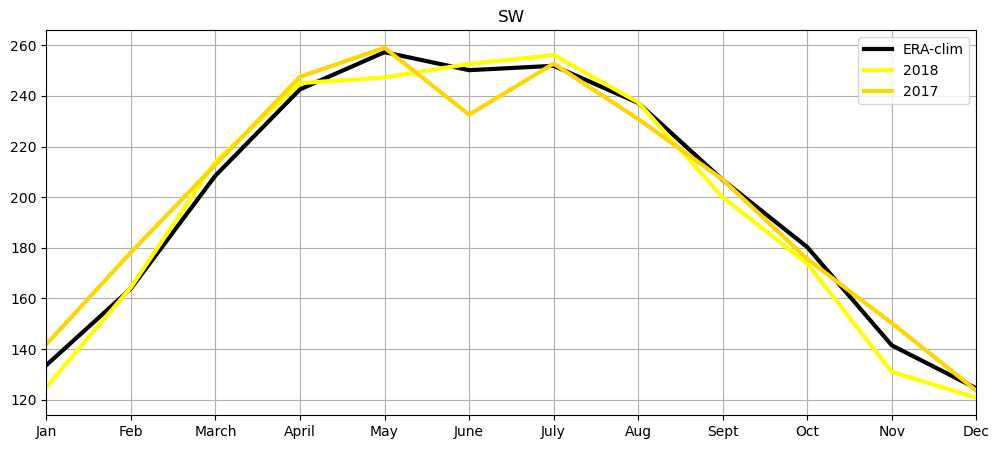

In [52]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]

plt.figure(figsize=(12,5))
plt.plot(months, mo_clim_e.ssr, label='ERA-clim', color='k', linewidth=3)
plt.plot(months, emonthly.ssr.sel(time=slice('2018', '2018')), label='2018', linewidth=3, color='yellow')
plt.plot(months, emonthly.ssr.sel(time=slice('2017', '2017')), label='2017', linewidth=3, color='gold')
plt.xlim('Jan', 'Dec')
plt.grid()
plt.legend()
plt.title('SW')

Text(0.5, 1.0, 'SST')

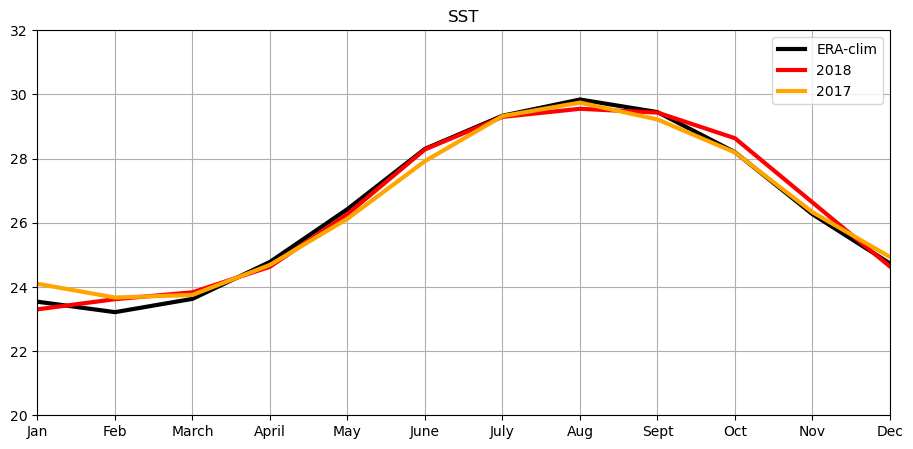

In [53]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]

plt.figure(figsize=(11,5))
plt.plot(months, mo_clim_e.sst, label='ERA-clim', color='k', linewidth=3)
plt.plot(months, emonthly.sst.sel(time=slice('2018', '2018')), label='2018', linewidth=3, color='red')
plt.plot(months, emonthly.sst.sel(time=slice('2017', '2017')), label='2017', linewidth=3, color='orange')
plt.xlim('Jan', 'Dec')
plt.grid()
plt.ylim(20,32)
plt.legend()
plt.title('SST')

### End of section

## Plot surf fluxes 

In [21]:
mo_clim_e = era.groupby('time.month').mean(['time', 'latitude', 'longitude'])
mo_anom_e = era.groupby('time.month') - mo_clim_e
mo_clim_m = merra.groupby('time.month').mean(['time', 'lat', 'lon'])
mo_anom_m = merra.groupby('time.month') - mo_clim_m

emonthly = era.resample(time='ME').mean().mean(['latitude', 'longitude'])
mmonthly = merra.resample(time='ME').mean().mean(['lat', 'lon'])

In [22]:
emonthly

<xarray.Dataset> Size: 8kB
Dimensions:  (time: 168)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2010-01-31 2010-02-28 ... 2023-12-31
Data variables:
    slhf     (time) float64 1kB -152.9 -149.2 -126.6 ... -162.9 -151.0 -150.7
    sshf     (time) float64 1kB -39.12 -39.3 -27.71 ... -26.22 -25.91 -23.36
    ssr      (time) float64 1kB 126.1 149.1 210.3 237.7 ... 175.7 133.7 116.8
    sst      (time) float64 1kB 0.08203 0.08187 0.08175 ... 0.08319 0.08265
    str      (time) float64 1kB -70.27 -67.53 -78.65 ... -63.25 -61.17 -66.51

In [23]:
mo_clim_e

<xarray.Dataset> Size: 576B
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    slhf     (month) float64 96B -136.6 -106.6 -107.4 ... -149.6 -150.6 -129.7
    sshf     (month) float64 96B -30.35 -25.17 -24.82 ... -23.29 -25.96 -24.5
    ssr      (month) float64 96B 133.6 163.9 208.5 242.6 ... 180.3 141.4 124.4
    sst      (month) float64 96B 0.08227 0.08219 0.08235 ... 0.08311 0.08264
    str      (month) float64 96B -68.82 -65.02 -69.93 ... -64.93 -65.92 -65.12
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-21 17:02:34 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [47]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]

def plot_clim_years(da, da_clim, model, flux, legend_xloc):
    plt.figure(figsize=(12,5))
    plt.plot(months, da_clim, label=f'{model}-clim', color='k', linewidth=3)
    plt.plot(months, da.sel(time=slice('2023', '2023')), label='2023', linewidth=3, color='red')
    
    for i in np.unique(da.time.dt.year)[:-1]:
        plt.plot(months, da[da.time.dt.year == i], label=f'{i}', alpha=0.5)
    plt.legend(bbox_to_anchor=(legend_xloc, 1.02), fancybox=True, shadow=True)
    plt.xlim('Jan', 'Dec')
    plt.grid()
    plt.title(f'2010-2023 {flux} against climatology \n {model}')
    plt.ylabel(r'W m$^{-2}$');


def plot_clim_some_yrs(da, da_clim, model, flux, legend_xloc):    
    plt.figure(figsize=(12,5))
    plt.plot(months, da_clim, label=f'{model}-clim', color='k', linewidth=3)
    plt.plot(months, da.sel(time=slice('2023', '2023')), label='2023', linewidth=3, color='red')
    plt.xlim('Jan', 'Dec')
    plt.grid()
    plt.title(f'2010-2023 {flux} against climatology \n (w some years skipped) {model}')
    
    yrs2keep = ['2010', '2011', '2014', '2019', '2020', '2021', '2022']
    for i in np.unique(da.time.dt.year):
        if str(i) in yrs2keep:
            plt.plot(months, da[da.time.dt.year == i], label=f'{i}', alpha=0.5)
            plt.legend(bbox_to_anchor=(legend_xloc, 1.02), fancybox=True, shadow=True)
            plt.ylabel(r'W m$^{-2}$');

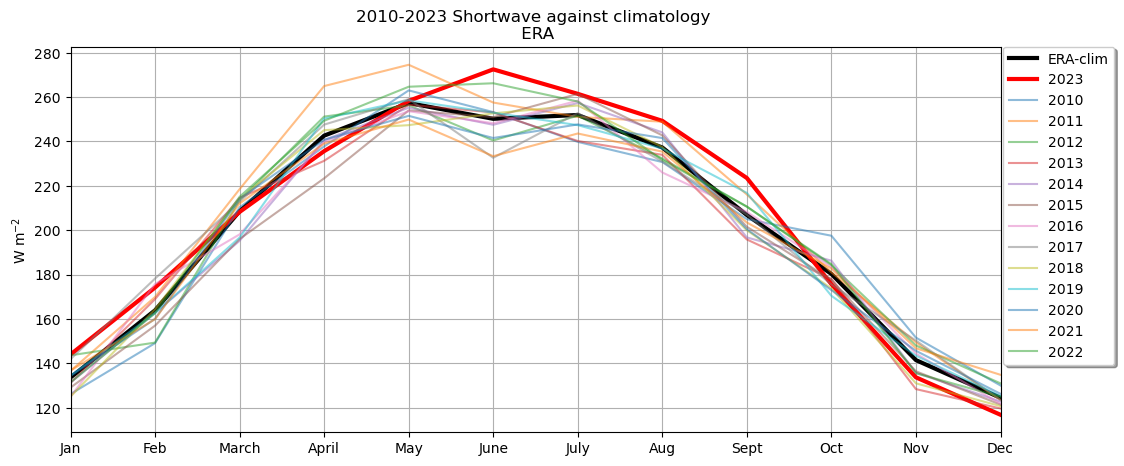

In [48]:
plot_clim_years(emonthly.ssr, mo_clim_e.ssr, 'ERA', 'Shortwave', 1.13)

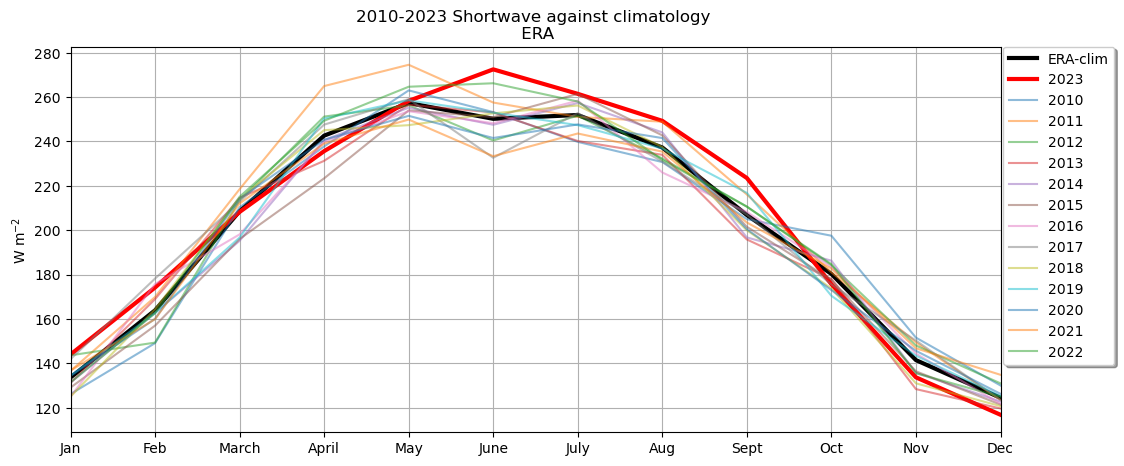

In [12]:
plot_clim_years(emonthly.ssr, mo_clim_e.ssr, 'ERA', 'Shortwave', 1.13)

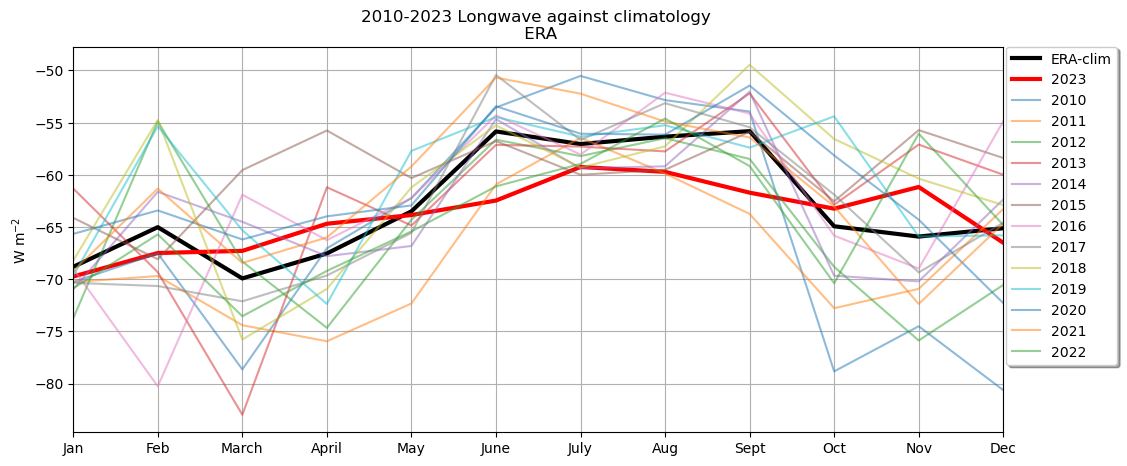

In [50]:
plot_clim_years(emonthly.str, mo_clim_e.str, 'ERA', 'Longwave', 1.13)

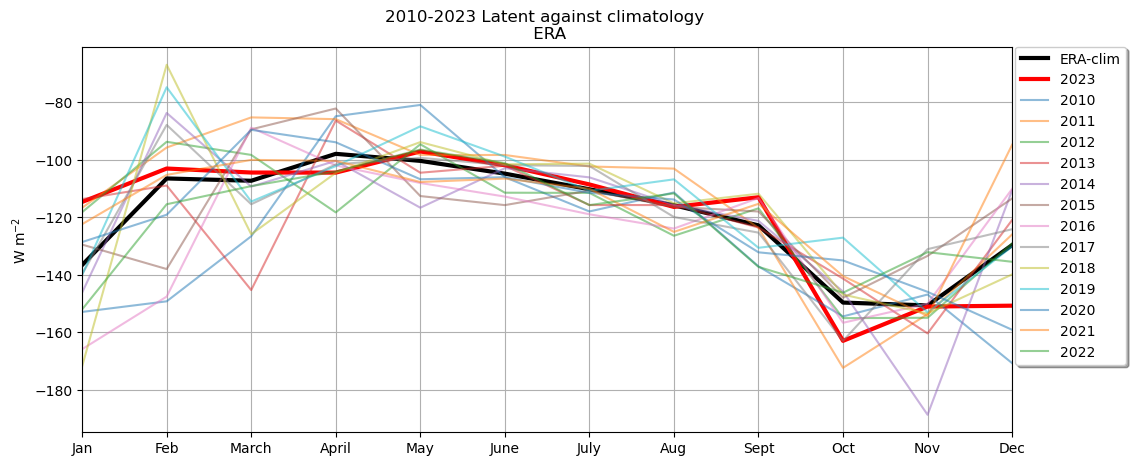

In [51]:
plot_clim_years(emonthly.slhf, mo_clim_e.slhf, 'ERA', 'Latent', 1.13)

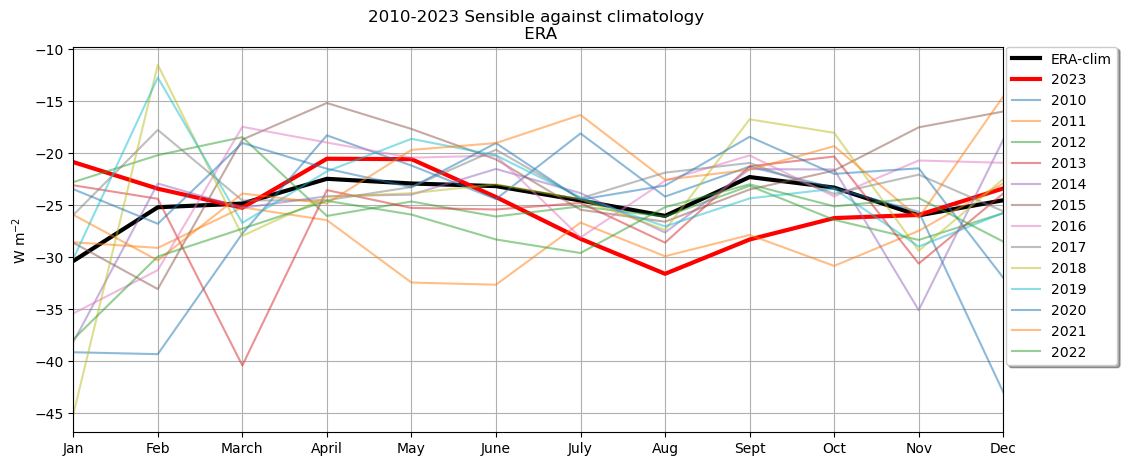

In [52]:
plot_clim_years(emonthly.sshf, mo_clim_e.sshf, 'ERA', 'Sensible', 1.13)

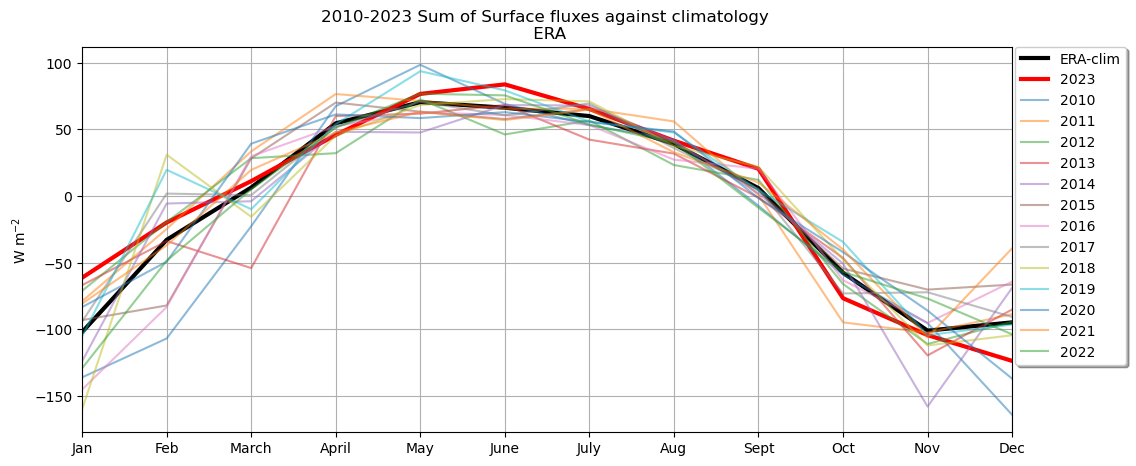

In [25]:
plot_clim_years(emonthly.drop_vars('sst').to_array().sum('variable'), 
                mo_clim_e.drop_vars('sst').to_array().sum('variable'), 
                'ERA', 'Sum of Surface fluxes', 1.13)

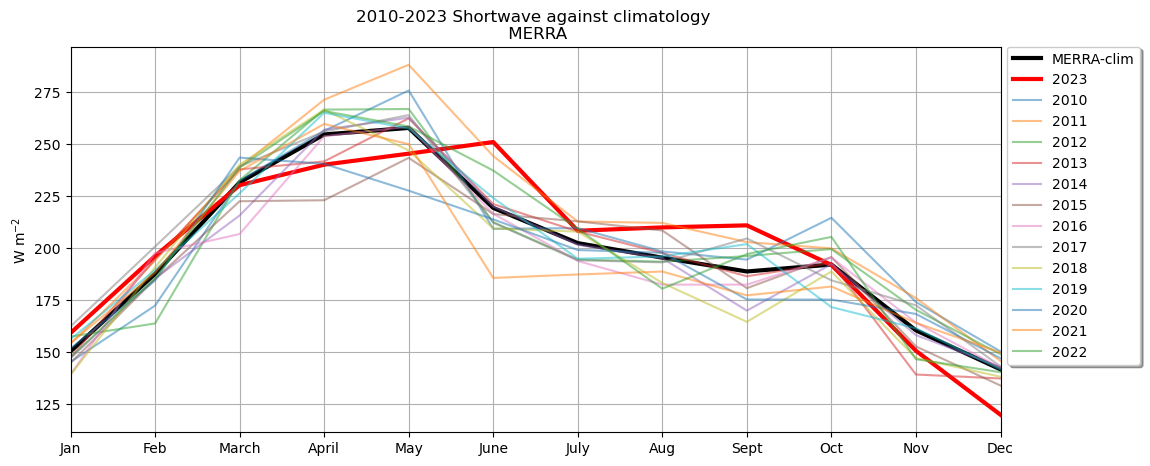

In [54]:
plot_clim_years(mmonthly.SWGNTWTR, mo_clim_m.SWGNTWTR, 'MERRA', 'Shortwave', 1.)

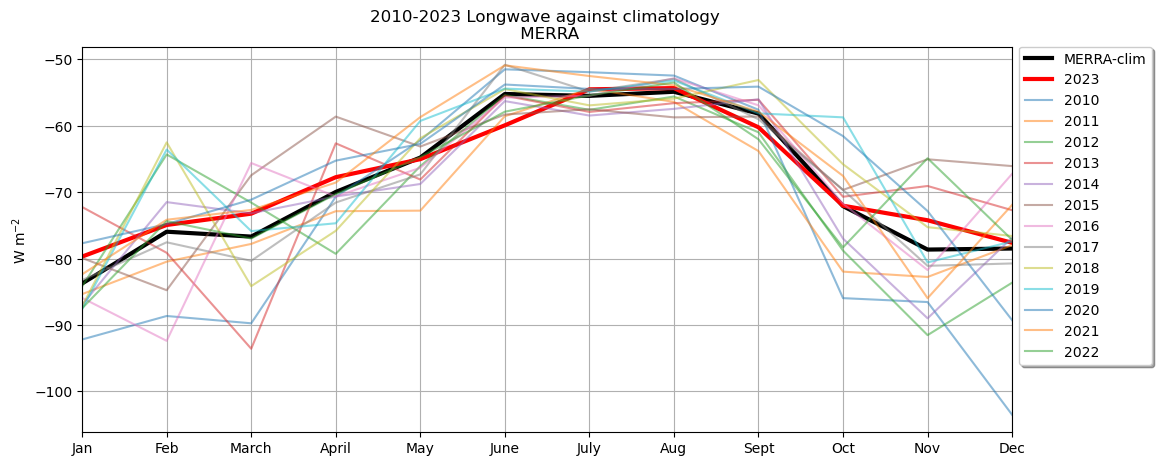

In [55]:
plot_clim_years(mmonthly.LWGNTWTR, mo_clim_m.LWGNTWTR, 'MERRA', 'Longwave', 1)

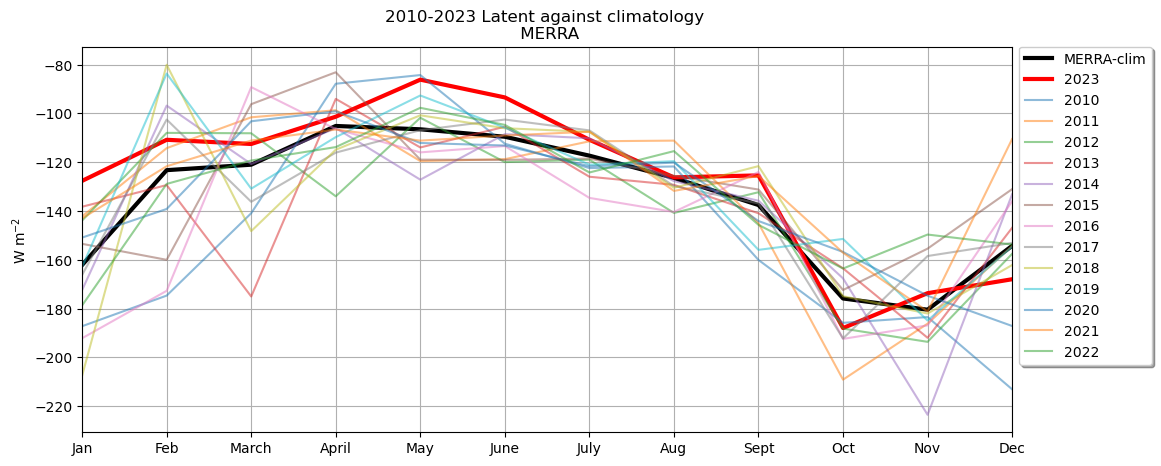

In [56]:
plot_clim_years(mmonthly.EFLUXWTR, mo_clim_m.EFLUXWTR, 'MERRA', 'Latent', 1)

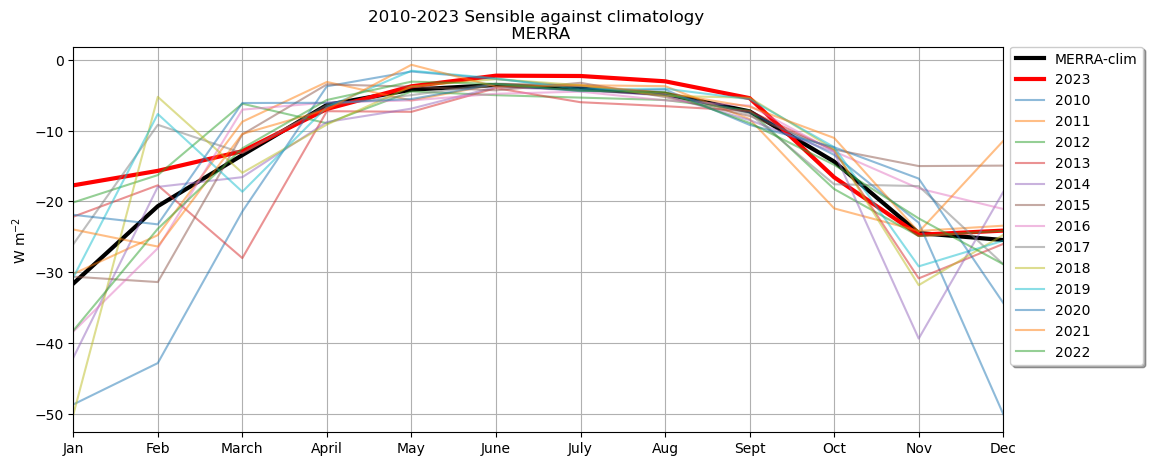

In [57]:
plot_clim_years(mmonthly.HFLUXWTR, mo_clim_m.HFLUXWTR, 'MERRA', 'Sensible', 1)

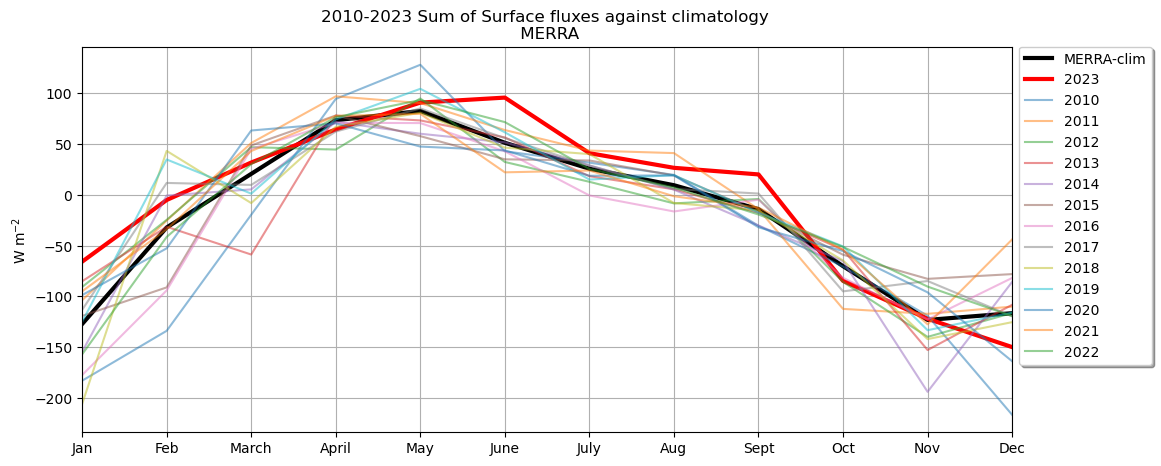

In [30]:
plot_clim_years(mmonthly.drop_vars('TSKINWTR').to_array().sum('variable'), 
                mo_clim_m.drop_vars('TSKINWTR').to_array().sum('variable'), 
                'MERRA', 'Sum of Surface fluxes', 1.)

## Plot some years

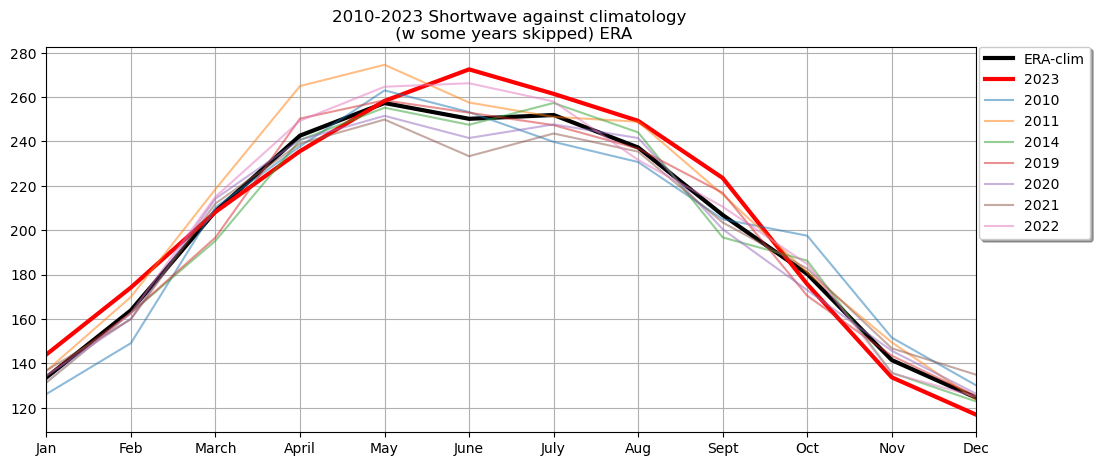

In [263]:
plot_clim_some_yrs(emonthly.ssr, mo_clim_e.ssr, 'ERA', 'Shortwave')

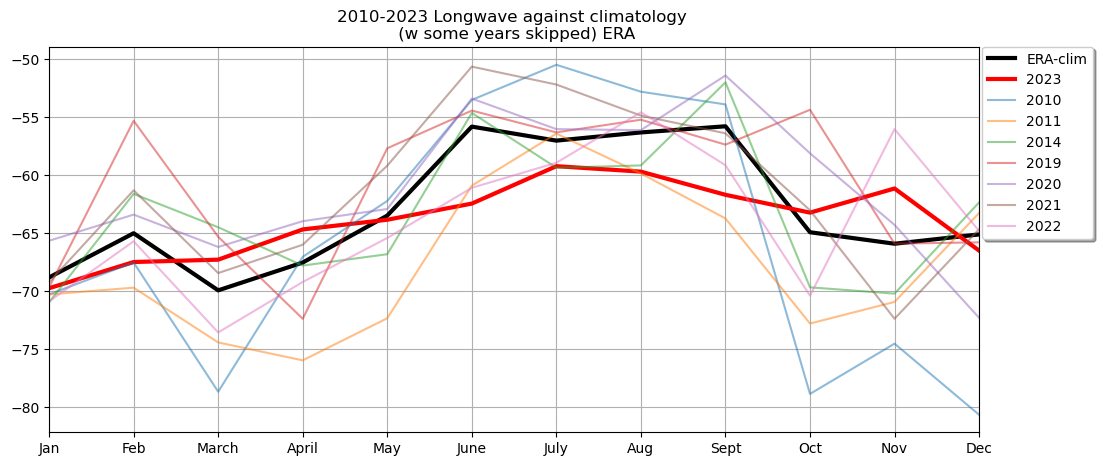

In [264]:
plot_clim_some_yrs(emonthly.str, mo_clim_e.str, 'ERA', 'Longwave')

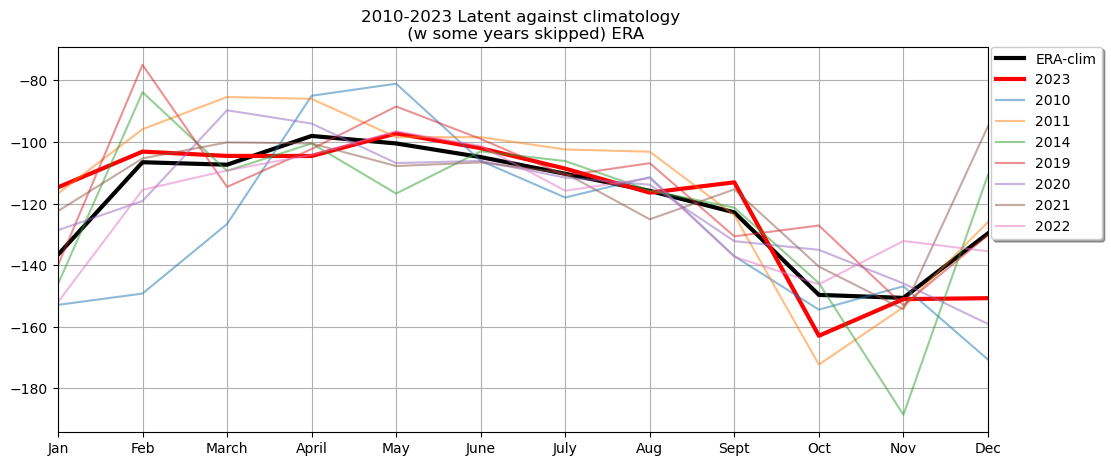

In [265]:
plot_clim_some_yrs(emonthly.slhf, mo_clim_e.slhf, 'ERA', 'Latent')

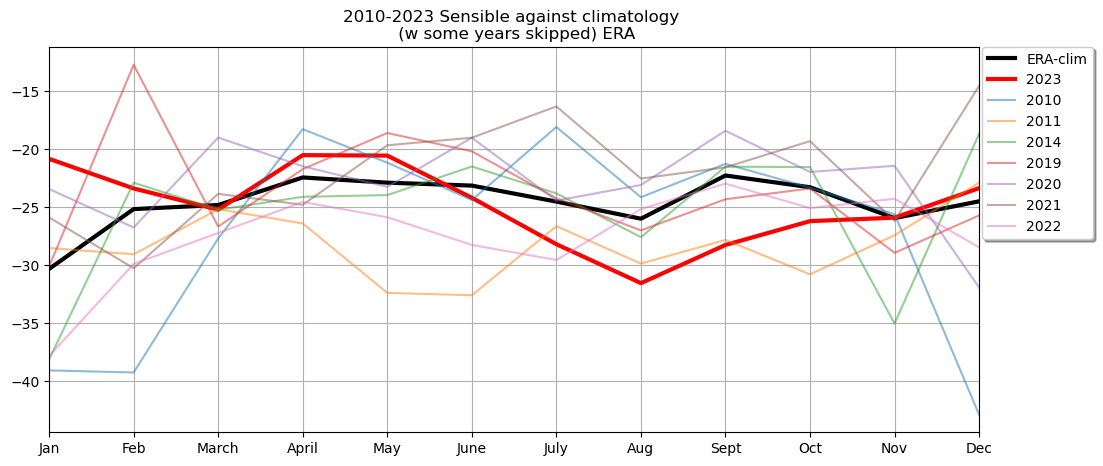

In [266]:
plot_clim_some_yrs(emonthly.sshf, mo_clim_e.sshf, 'ERA', 'Sensible')

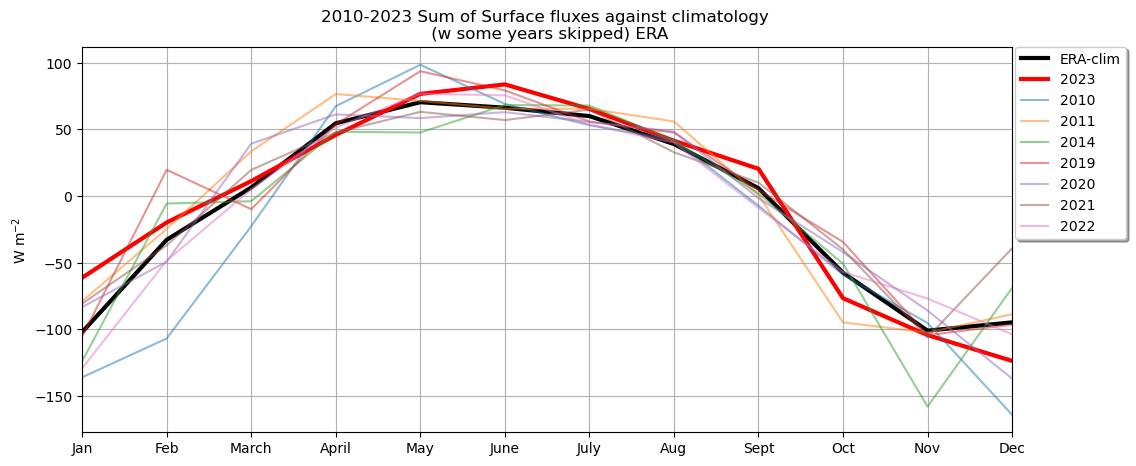

In [28]:
plot_clim_some_yrs(emonthly.drop_vars('sst').to_array().sum('variable'), 
                    mo_clim_e.drop_vars('sst').to_array().sum('variable'), 
                    'ERA', 'Sum of Surface fluxes', 1.13)

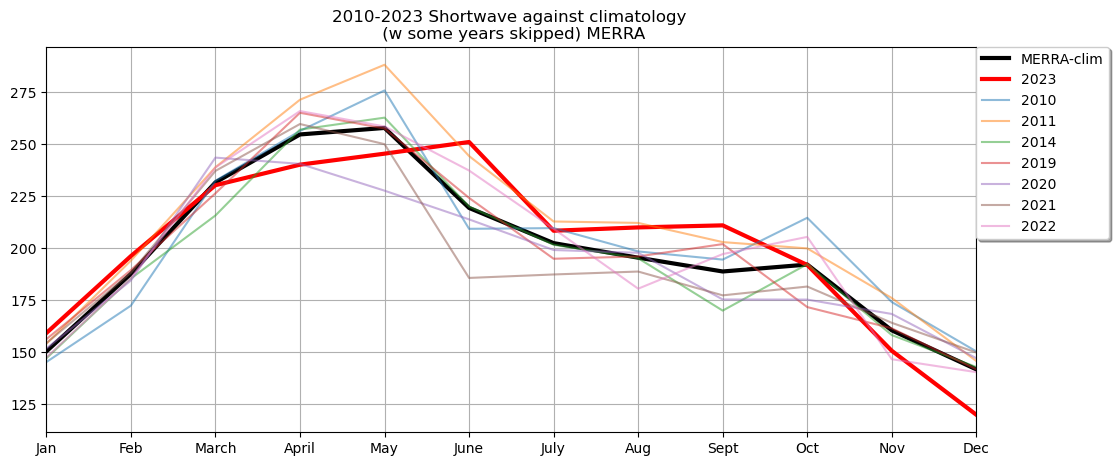

In [64]:
plot_clim_some_yrs(mmonthly.SWGNTWTR, mo_clim_m.SWGNTWTR, 'MERRA', 'Shortwave', 1.15)

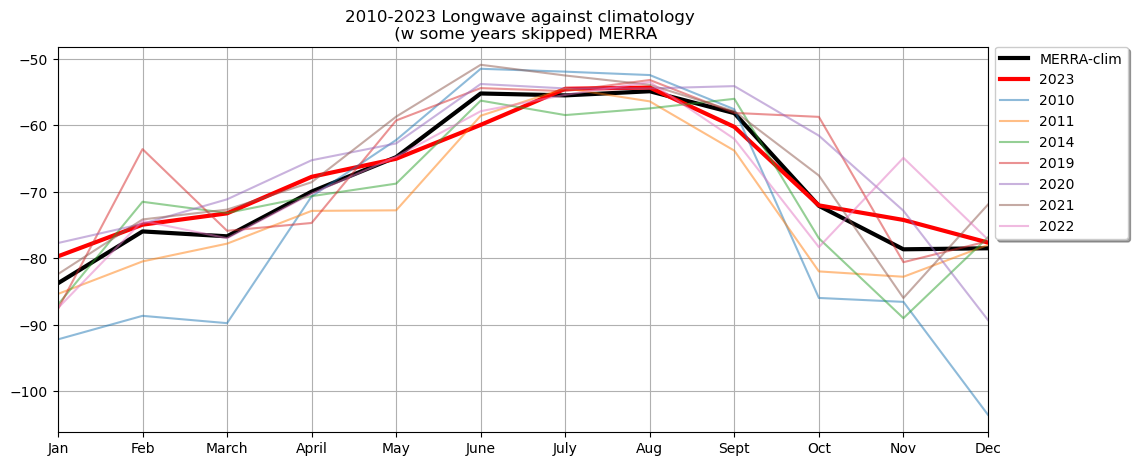

In [68]:
plot_clim_some_yrs(mmonthly.LWGNTWTR, mo_clim_m.LWGNTWTR, 'MERRA', 'Longwave', 1.)

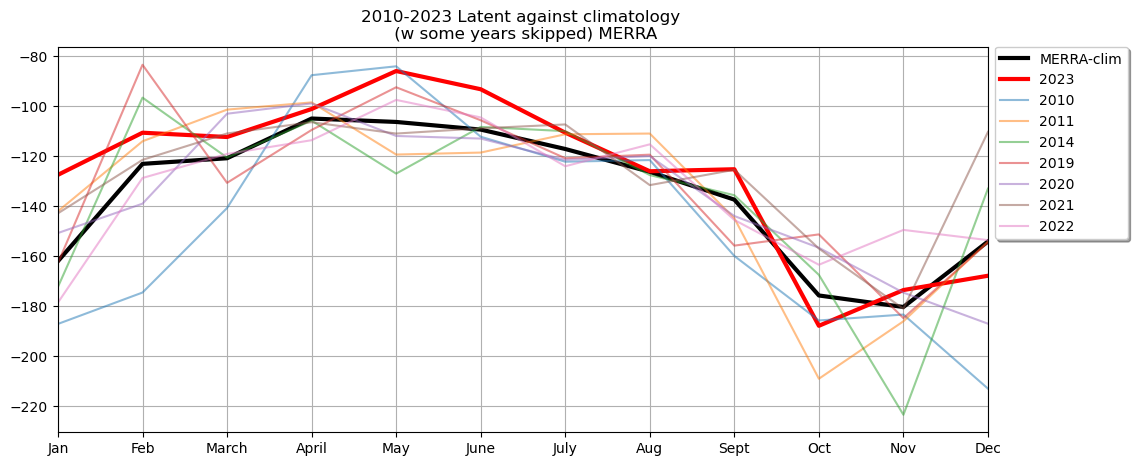

In [69]:
plot_clim_some_yrs(mmonthly.EFLUXWTR, mo_clim_m.EFLUXWTR, 'MERRA', 'Latent', 1.)

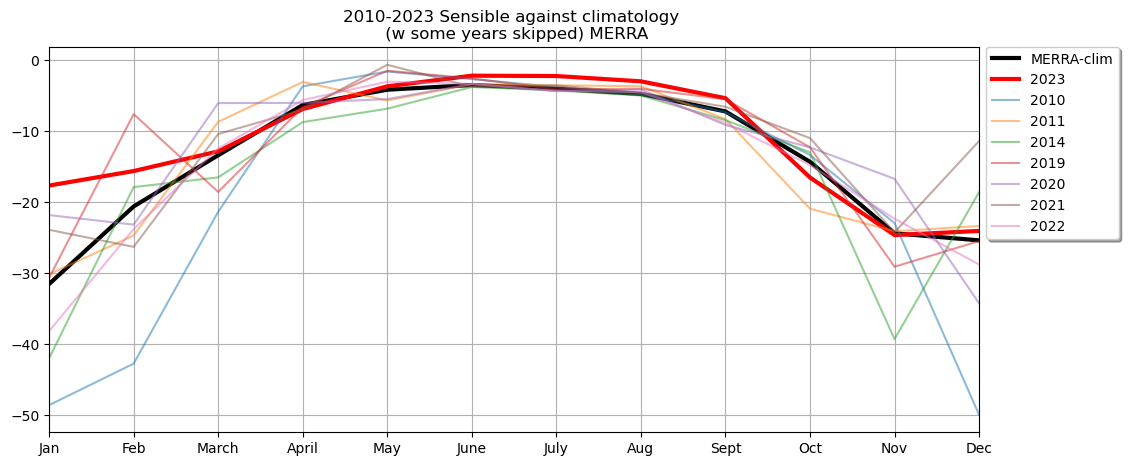

In [70]:
plot_clim_some_yrs(mmonthly.HFLUXWTR, mo_clim_m.HFLUXWTR, 'MERRA', 'Sensible', 1)

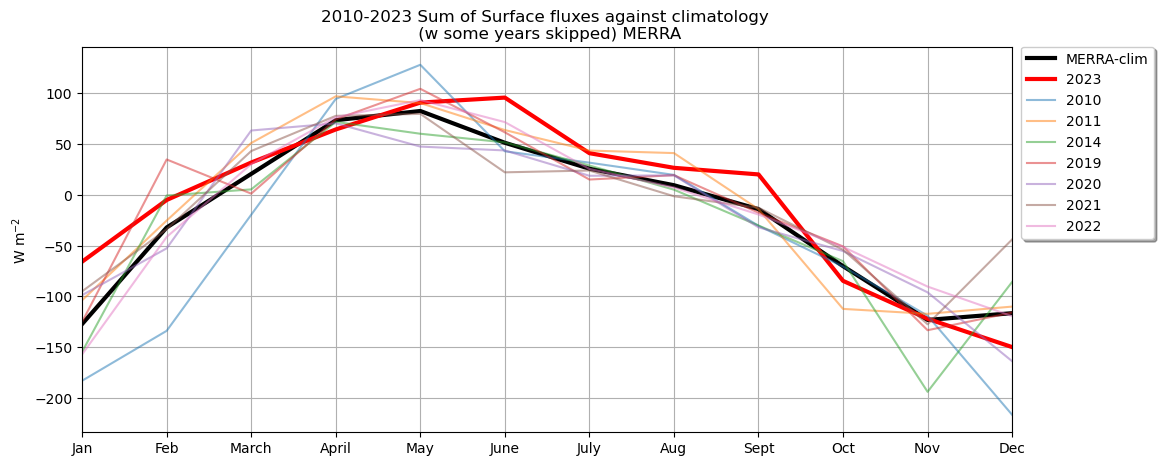

In [34]:
plot_clim_some_yrs(mmonthly.drop_vars('TSKINWTR').to_array().sum('variable'), 
                   mo_clim_m.drop_vars('TSKINWTR').to_array().sum('variable'), 
                   'MERRA', 'Sum of Surface fluxes', 1.16)

In [159]:
def plot_clims(da_e, da_m, fig_title):
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

    mo_clim_e[f'{da_e}'].plot(ax=ax0, label='ERA')
    mo_clim_m[f'{da_m}'].plot(ax=ax0, label='MERRA')
    ax0.set_title('monthly climatology')
    ax0.grid()
    ax0.legend()
    
    mo_anom_e[f'{da_e}'].mean(['latitude', 'longitude']).plot(label='ERA', ax=ax1)
    mo_anom_m[f'{da_m}'].mean(['lat', 'lon']).plot(ax=ax1, label='MERRA', linestyle='--')
    ax1.set_title('monthly anomaly')
    ax1.grid()
    ax1.legend()
    
    plt.tight_layout()
    plt.suptitle(f'{fig_title}', y=1.05);

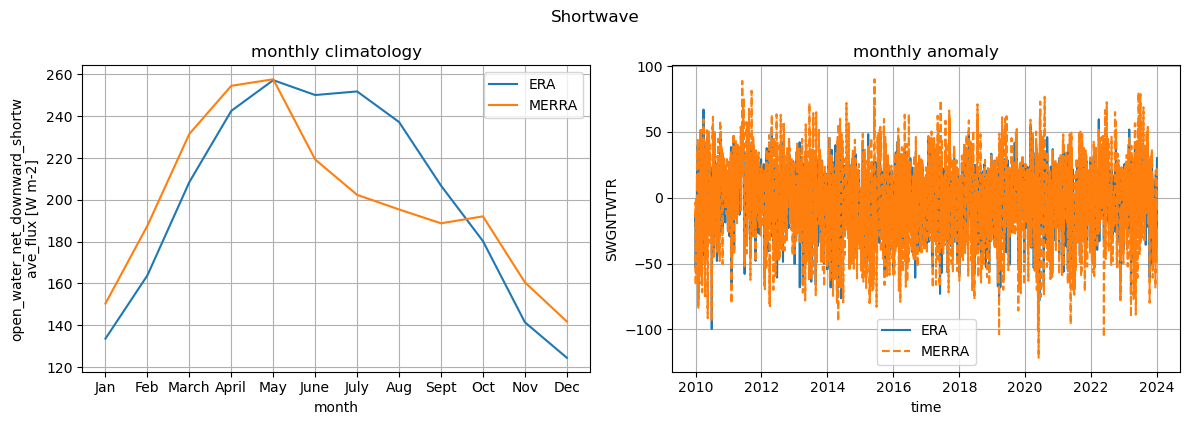

In [160]:
plot_clims('ssr', 'SWGNTWTR', 'Shortwave')

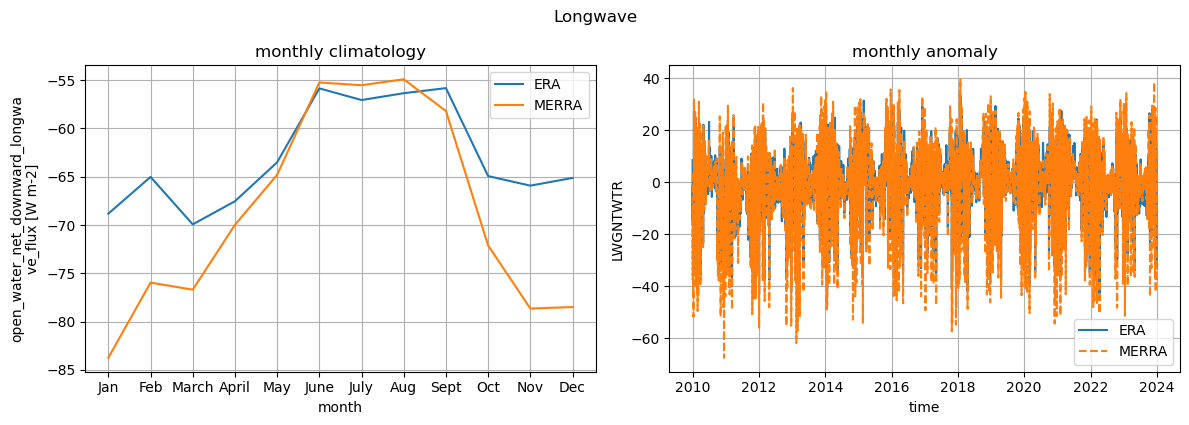

In [161]:
plot_clims('str', 'LWGNTWTR', 'Longwave')

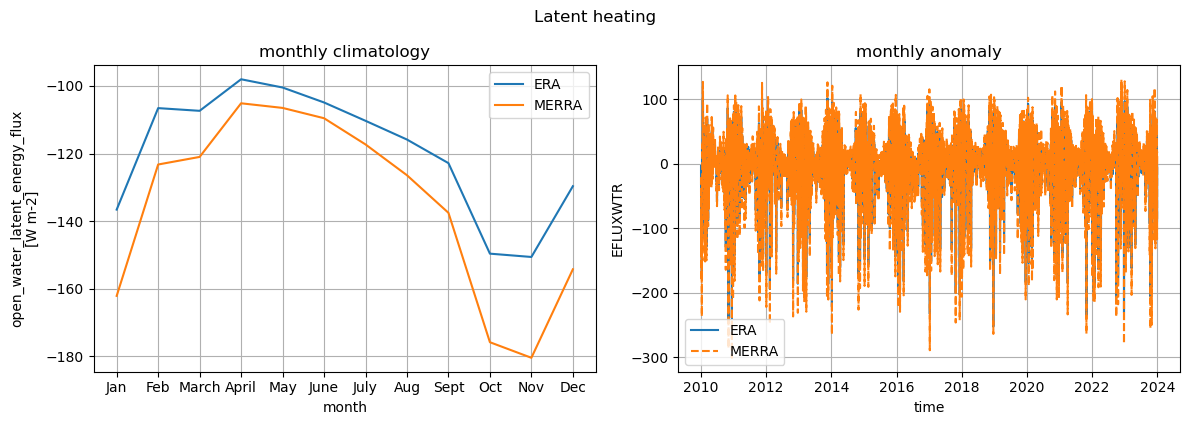

In [162]:
plot_clims('slhf', 'EFLUXWTR', 'Latent heating')

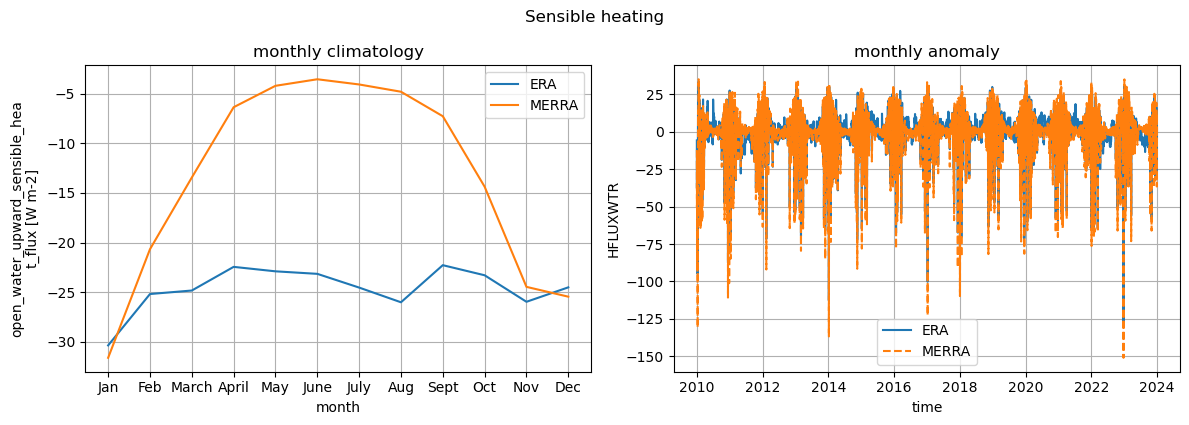

In [163]:
plot_clims('sshf', 'HFLUXWTR', 'Sensible heating')

## Detrended Shortwave

In [17]:
detrend_e = xr.apply_ufunc(detrend, era.fillna(0.), kwargs=dict(axis=-1),
                                   input_core_dims=[['time']],
                                   output_core_dims=[['time']],
                                   output_dtypes=[era.ssr.dtype],
                                   dask='parallelized').reset_coords(drop=True)

In [18]:
detrend_m = xr.apply_ufunc(detrend, merra.fillna(0.), kwargs=dict(axis=-1),
                                   input_core_dims=[['time']],
                                   output_core_dims=[['time']],
                                   output_dtypes=[merra.SWGNTWTR.dtype],
                                   dask='parallelized').reset_coords(drop=True)

In [19]:
detrend_e

<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 41, longitude: 113, time: 5019)
Coordinates:
  * latitude   (latitude) float32 164B 21.0 21.25 21.5 21.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 40kB 2010-01-01 2010-01-02 ... 2023-09-28
Data variables:
    slhf       (latitude, longitude, time) float64 186MB 42.24 41.75 ... 135.0
    sshf       (latitude, longitude, time) float64 186MB 40.03 33.83 ... 7.147
    ssr        (latitude, longitude, time) float64 186MB -150.8 ... -191.6
    sst        (latitude, longitude, time) float64 186MB 0.0 0.0 ... -0.08276
    str        (latitude, longitude, time) float64 186MB 42.89 33.69 ... 28.44
    ssrd       (latitude, longitude, time) float64 186MB 0.0 0.0 ... 62.22 -46.2
    strd       (latitude, longitude, time) float64 186MB 0.0 0.0 ... 335.6 345.7

In [20]:
detrend_m

<xarray.Dataset> Size: 95MB
Dimensions:   (lat: 21, lon: 45, time: 5019)
Coordinates:
  * lat       (lat) float64 168B 21.0 21.5 22.0 22.5 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time      (time) datetime64[ns] 40kB 2010-01-01 2010-01-02 ... 2023-09-28
Data variables:
    EFLUXWTR  (lat, lon, time) float32 19MB 0.0 0.0 0.0 ... 94.53 42.83 -13.85
    HFLUXWTR  (lat, lon, time) float32 19MB 0.0 0.0 0.0 ... 9.043 6.941 1.803
    LWGNTWTR  (lat, lon, time) float32 19MB 0.0 0.0 0.0 0.0 ... 12.0 21.31 20.73
    SWGNTWTR  (lat, lon, time) float32 19MB 0.0 0.0 0.0 ... 11.21 -43.58 -66.16
    TSKINWTR  (lat, lon, time) float32 19MB 0.0 0.0 0.0 0.0 ... 2.288 2.29 2.237

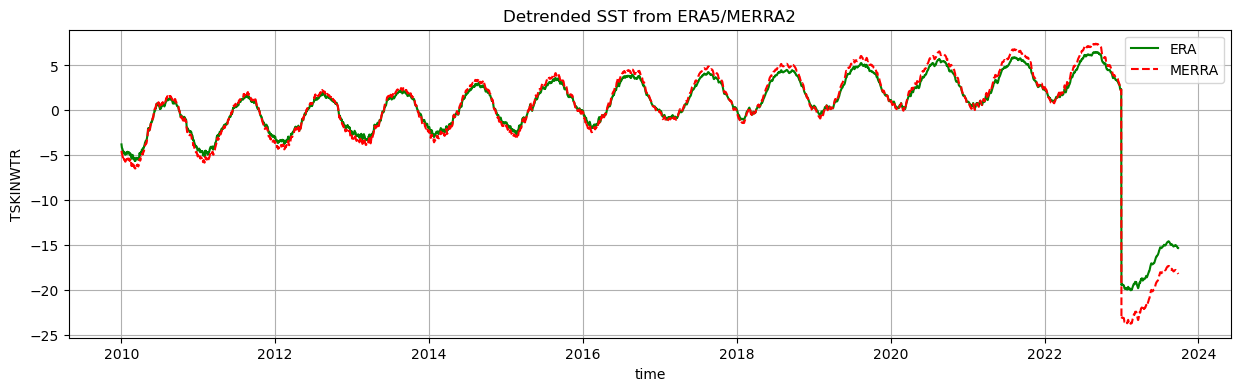

In [38]:
#multiply by hrs in a day to get back era sst values
(detrend_e.sst*60*60).mean(['latitude', 'longitude']).isel(time=slice(None, -1)).plot(figsize=(15,4), color='green', label='ERA')
(detrend_m.TSKINWTR).mean(['lat', 'lon']).plot(color='red', linestyle='--',label='MERRA')
plt.grid()
plt.legend()
plt.title('Detrended SST from ERA5/MERRA2');

In [23]:
mo_clim_de = detrend_e.groupby('time.month').mean(['time']).mean(['latitude', 'longitude'])
mo_anom_de = detrend_e.groupby('time.month') - mo_clim_de

mo_clim_dm = detrend_m.groupby('time.month').mean(['time']).mean(['lat', 'lon'])
mo_anom_dm = detrend_m.groupby('time.month') - mo_clim_dm

In [24]:
def plot_detrended_clims(da_e, da_m, fig_title):
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

    mo_clim_de[f'{da_e}'].plot(ax=ax0, label='ERA')
    mo_clim_dm[f'{da_m}'].plot(ax=ax0, label='MERRA')
    ax0.set_title('monthly climatology detrended')
    ax0.grid()
    ax0.legend()
    
    mo_anom_de[f'{da_e}'].mean(['latitude', 'longitude']).plot(label='ERA', ax=ax1)
    mo_anom_dm[f'{da_m}'].mean(['lat', 'lon']).plot(ax=ax1, label='MERRA', linestyle='--')
    ax1.set_title('monthly anomaly detrended')
    ax1.grid()
    ax1.legend()
    
    plt.tight_layout()
    plt.suptitle(f'{fig_title} - detrended', y=1.05);

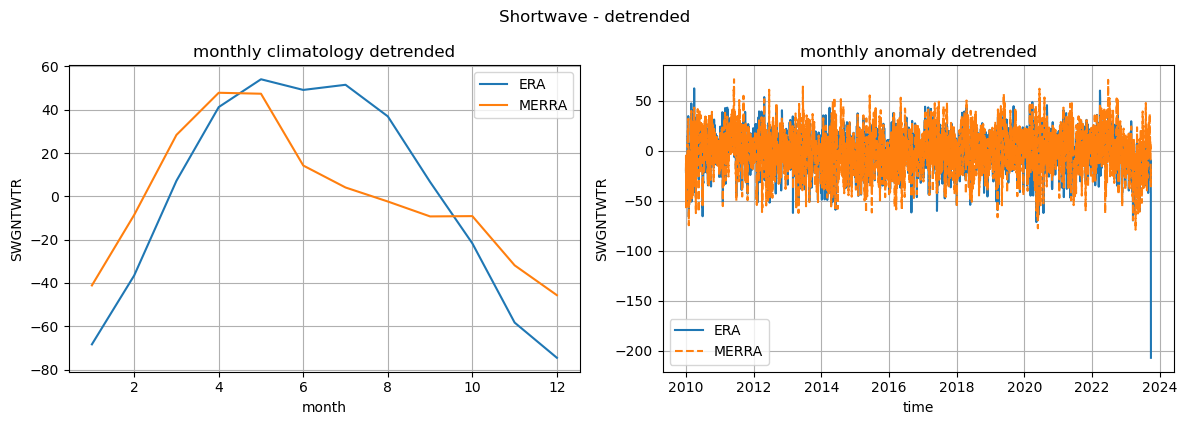

In [25]:
plot_detrended_clims('ssr', 'SWGNTWTR', 'Shortwave')

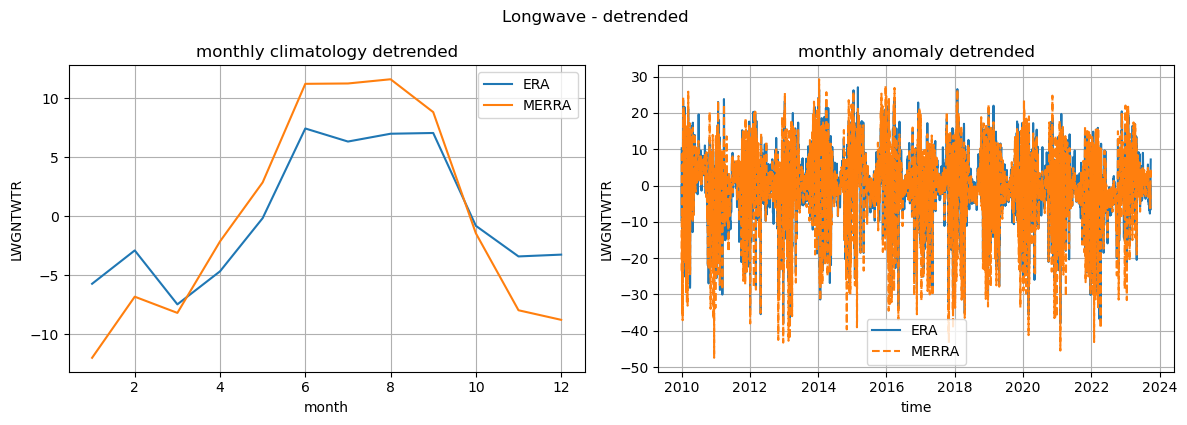

In [26]:
plot_detrended_clims('str', 'LWGNTWTR', 'Longwave')

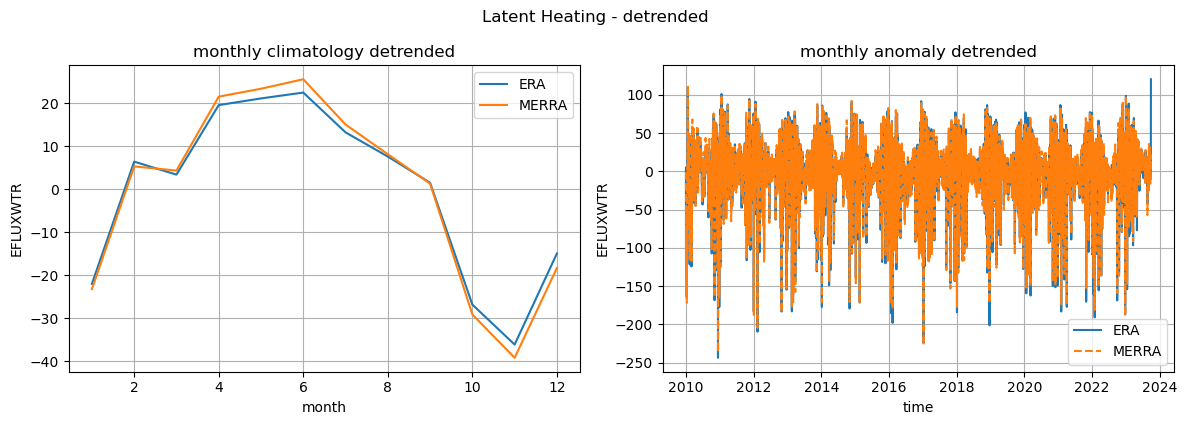

In [27]:
plot_detrended_clims('slhf', 'EFLUXWTR', 'Latent Heating')

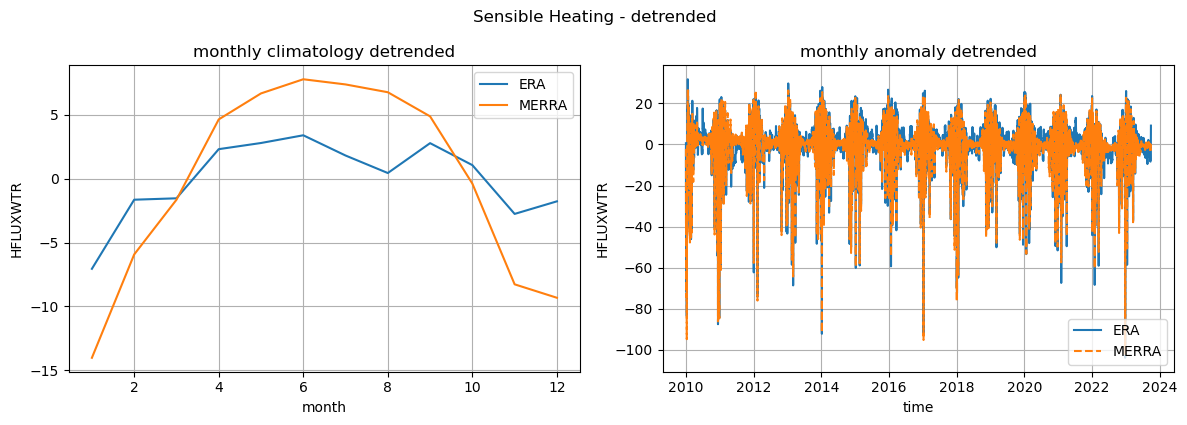

In [28]:
plot_detrended_clims('sshf', 'HFLUXWTR', 'Sensible Heating')